In [1]:
#%pip install statsmodels

### First, import packages and set default plotting parameters

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.optimize import curve_fit
from venn import venn
import seaborn as sns
from matplotlib.colors import LogNorm
import statsmodels.api as sm

In [3]:
# Set seaborn theme to white
sns.set_theme(style='white')

# set up matplotlib theme
andy_theme = {'axes.grid': False,
              'grid.linestyle': '--',
              'legend.framealpha': 1,
              'legend.facecolor': 'white',
              'legend.shadow': False,
              'legend.fontsize': 14,
              'legend.title_fontsize': 14,
              'font.sans-serif':'Helvetica',
              'xtick.labelsize': 12,
              'ytick.labelsize': 12,
              'axes.labelsize': 16,
              'axes.titlesize': 18,
              'figure.dpi': 300}
plt.rcParams.update(andy_theme)

#Uncomment next 2 lines if matplotlib can not find Helvetica font
#plt.rcParams['font.family'] = 'DeJavu Serif'
#plt.rcParams['font.sans-serif'] = ['Arial']

## 1. FIRST ORDER ANALYSES

### Load the datasets with neurons and connections.

* This script assumes that the **CSV** files (`.csv.gz`) and **aStN-SAs lists** (`_new.csv` files) are in the same folder as this notebook or script.
* These files include four CSVs containing manually curated  aStN-SAs lists and four connectome datasets from FlyWire:
  1. **`classification.csv.gz`**
  2. **`connections.csv.gz`**
  3. **`neuropil_synapse_table.csv.gz`**
  4. **`neurons.csv.gz`**
* **Axon lists** were curated manually as described in the paper.
* **Connectome datasets** were downloaded from the FlyWire website using **snapshot 783** (previous snapshot 630).
* We focus on putative sensory axons from the Drosophila **pharyngeal nerve** in this analysis.


In [4]:
# Connections dataset and additional data sets
connections = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/'
    'YaoLabUF/YaoLab/Drosophila_brain_model/connections.csv.gz'
)

neuropil_synapse = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/'
    'YaoLabUF/YaoLab/Drosophila_brain_model/neuropil_synapse_table.csv.gz'
)[['root_id', 'input synapses', 'output synapses']]
neuropil_synapse.rename(
    columns={'input synapses': 'input_synapses', 'output synapses': 'output_synapses'},
    inplace=True
)

classification = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/'
    'YaoLabUF/YaoLab/Drosophila_brain_model/classification.csv.gz'
)[['root_id', 'side']]
classification_other = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/'
    'YaoLabUF/YaoLab/Drosophila_brain_model/classification.csv.gz'
)[['root_id', 'super_class', 'class', 'nerve']]

neurons = pd.read_csv('/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model/neurons.csv.gz')[['root_id', 'nt_type']]

neurons_data = pd.merge(
    neurons,
    pd.merge(classification, neuropil_synapse, on='root_id', how='outer'),
    on='root_id', how='outer'
)

# Load putative StN-SA lists (six sets)
set_1 = pd.read_csv('/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_1.csv')
set_2 = pd.read_csv('/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_2.csv')
set_3 = pd.read_csv('/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_3.csv')
set_4 = pd.read_csv('/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_4.csv')
set_5 = pd.read_csv('/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_5.csv')
set_6 = pd.read_csv('/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_6.csv')


In [5]:
#fig.show(renderer="browser")
#fig.write_html("sankey_diagram.html")

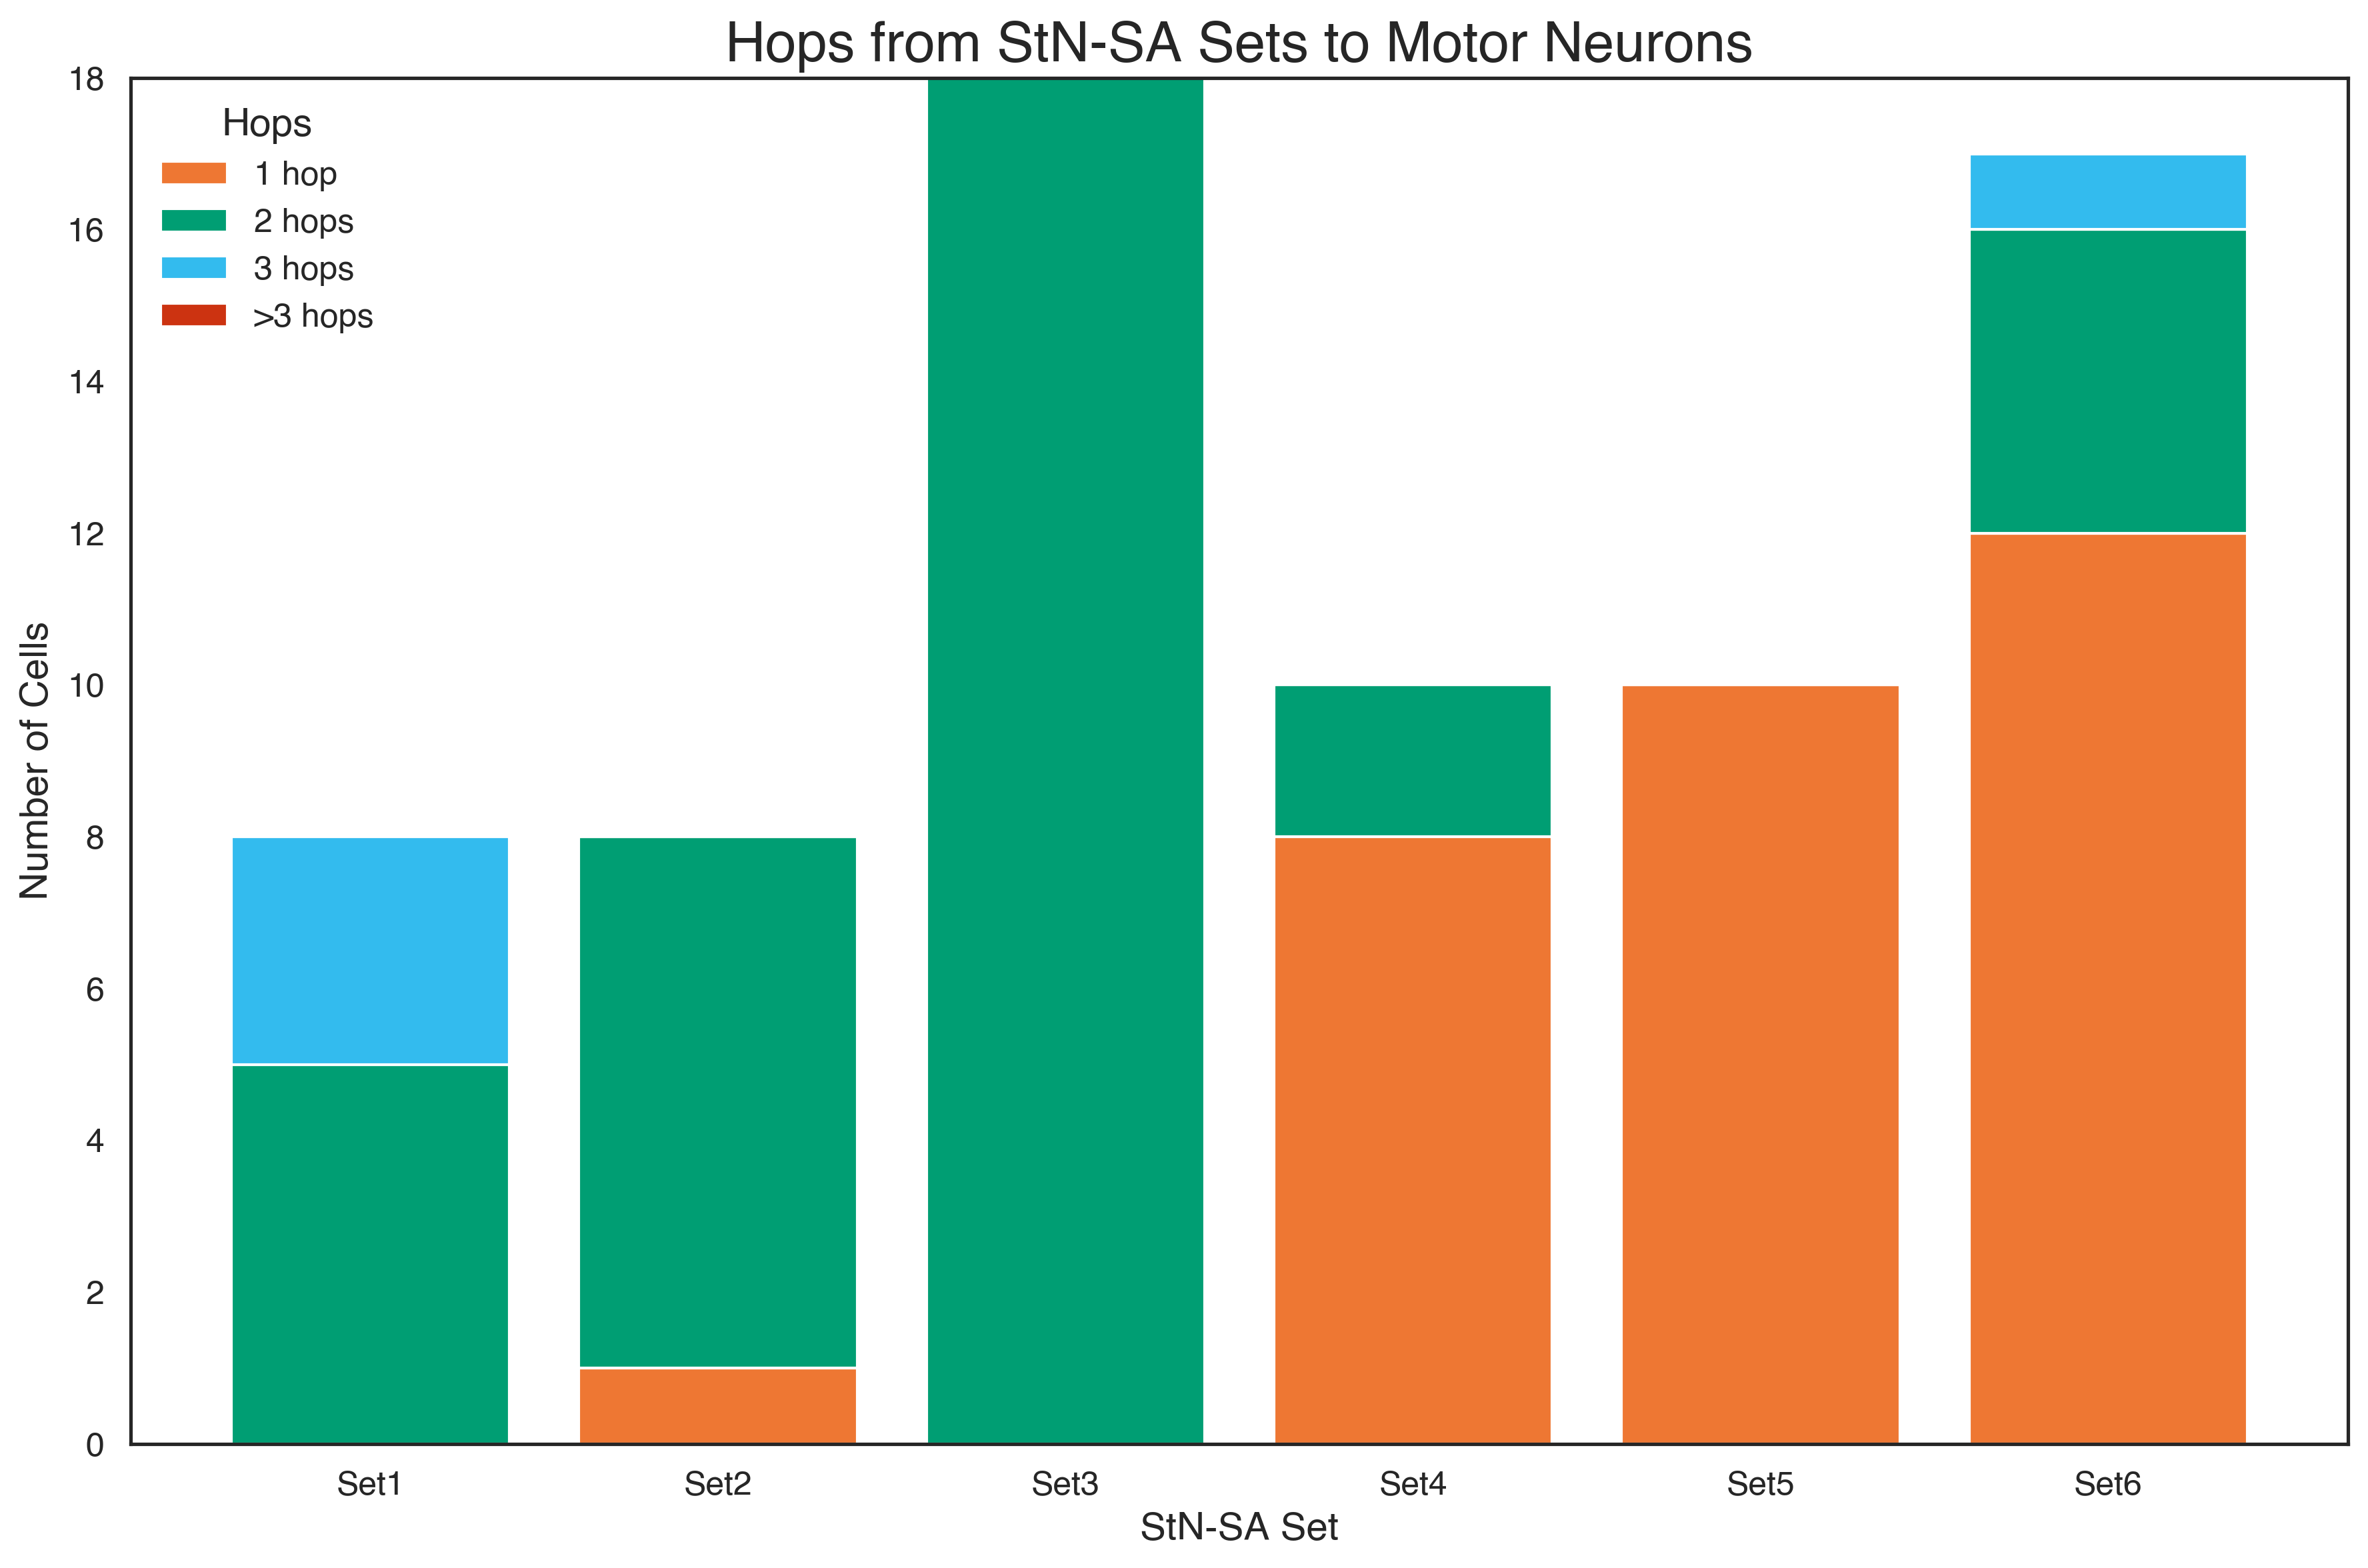

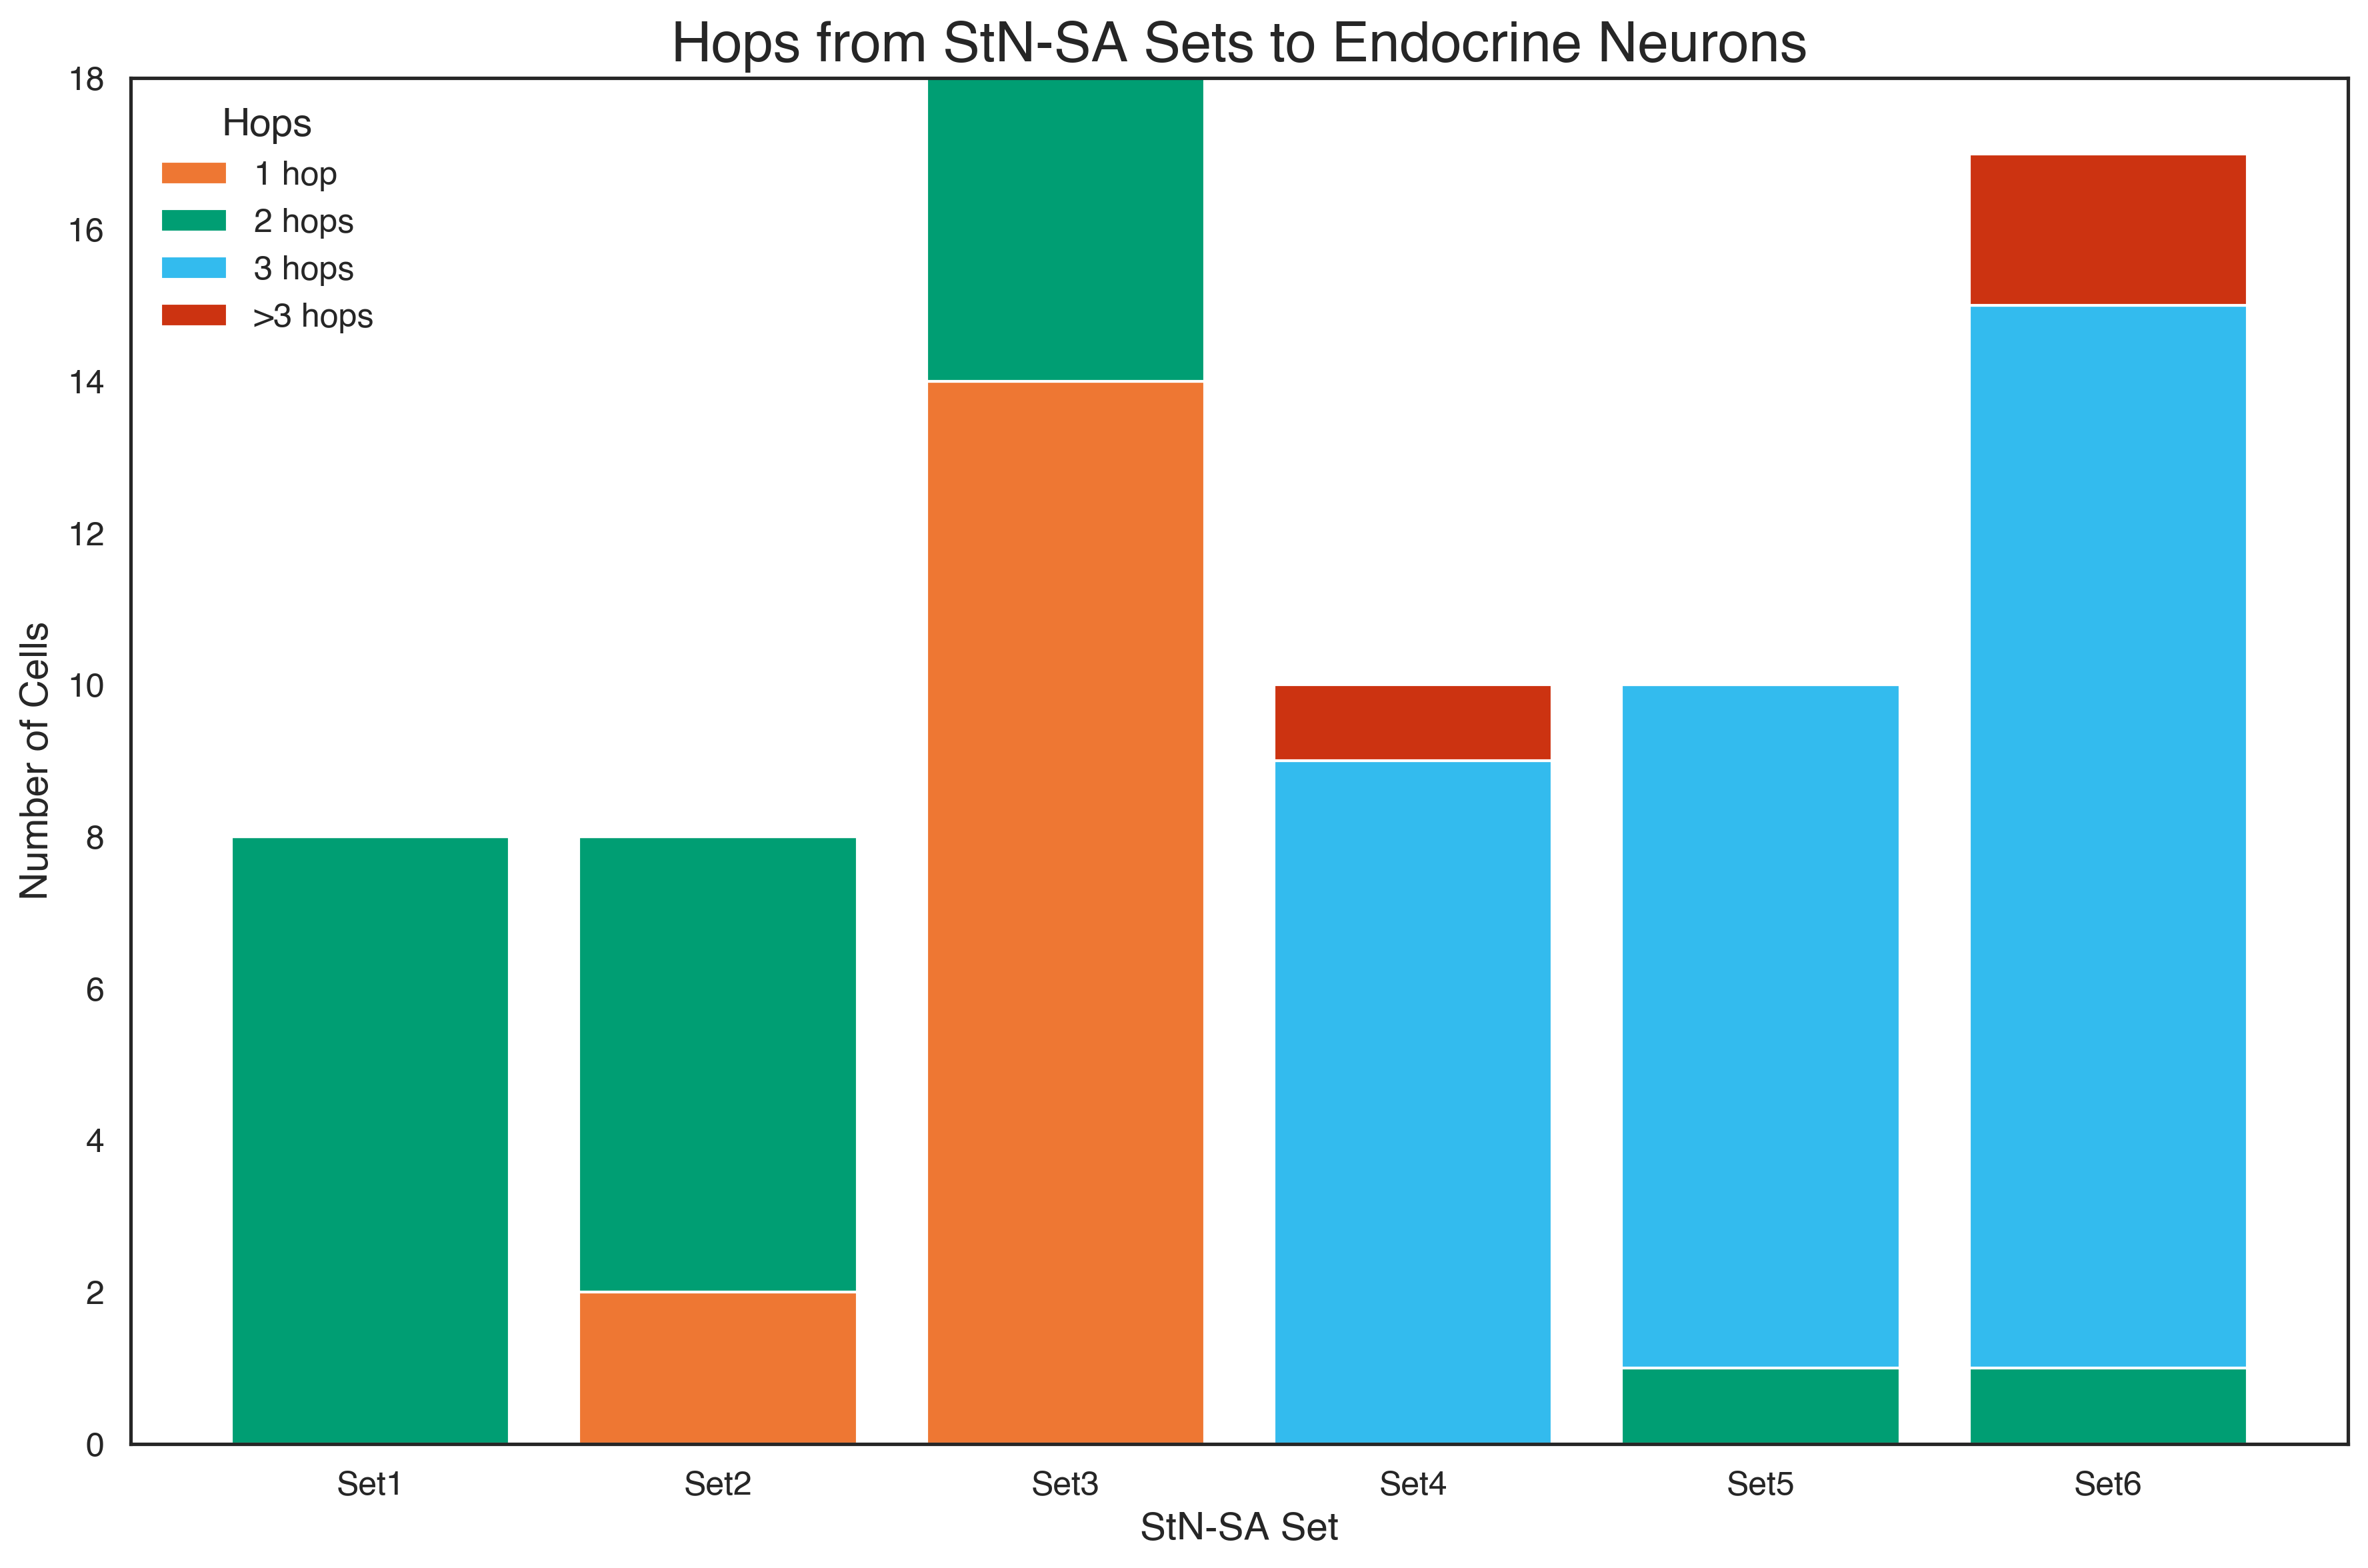

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import deque, defaultdict

# ───────────────────────────────────────────────────────────────────────────────
# 0. LOAD ALL YOUR DATASETS
# ───────────────────────────────────────────────────────────────────────────────
connections = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/'
    'YaoLabUF/YaoLab/Drosophila_brain_model/connections.csv.gz'
)

neuropil_synapse = (
    pd.read_csv(
        '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/'
        'YaoLabUF/YaoLab/Drosophila_brain_model/neuropil_synapse_table.csv.gz'
    )
    [['root_id','input synapses','output synapses']]
    .rename(columns={
        'input synapses':'input_synapses',
        'output synapses':'output_synapses'
    })
)

classification_side = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/'
    'YaoLabUF/YaoLab/Drosophila_brain_model/classification.csv.gz'
)[['root_id','side']]

classification_other = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/'
    'YaoLabUF/YaoLab/Drosophila_brain_model/classification.csv.gz'
)[['root_id','super_class']]

super_map = classification_other.set_index('root_id')['super_class'].to_dict()

neurons = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/'
    'YaoLabUF/YaoLab/Drosophila_brain_model/neurons.csv.gz'
)[['root_id','nt_type']]

neurons_data = pd.merge(
    neurons,
    pd.merge(classification_side, neuropil_synapse, on='root_id', how='outer'),
    on='root_id',
    how='outer'
)

# ───────────────────────────────────────────────────────────────────────────────
# 1. BUILD THRESHOLDED ADJACENCY LIST (≥5 synapses)
# ───────────────────────────────────────────────────────────────────────────────
edge_df = (
    connections
    .groupby(['pre_root_id','post_root_id'], as_index=False)
    .agg({'syn_count':'sum'})
    .query('syn_count >= 5')
    [['pre_root_id','post_root_id']]
)

adj = defaultdict(set)
for u, v in edge_df.values:
    adj[int(u)].add(int(v))

# ───────────────────────────────────────────────────────────────────────────────
# 2. LOAD YOUR SIX StN-SA_v2 SETS & DEFINE THE “sets” DICT
# ───────────────────────────────────────────────────────────────────────────────
sets = {
    f'Set{i}': pd.read_csv(
        f'/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_{i}.csv'
    )['root_id'].astype(int)
    for i in range(1, 7)
}

# ───────────────────────────────────────────────────────────────────────────────
# 3. BFS HELPER TO COMPUTE MINIMAL HOPS TO A TARGET CLASS
# ───────────────────────────────────────────────────────────────────────────────
def compute_hops(src_ids, target_class):
    hop_of = {}
    for src in src_ids:
        if src not in adj:
            hop_of[src] = None
            continue

        visited = {src}
        queue = deque([(src, 0)])
        found = None

        while queue and found is None:
            node, dist = queue.popleft()
            if dist >= 3:
                continue
            for nei in adj[node]:
                if nei in visited:
                    continue
                visited.add(nei)
                nd = dist + 1
                if super_map.get(nei) == target_class:
                    found = nd
                    break
                queue.append((nei, nd))

        hop_of[src] = found

    counts = {'1':0,'2':0,'3':0,'>3':0}
    for h in hop_of.values():
        if h in (1,2,3):
            counts[str(h)] += 1
        else:
            counts['>3'] += 1

    return pd.DataFrame({
        'hop':  ['1','2','3','>3'],
        'count':[counts['1'],counts['2'],counts['3'],counts['>3']]
    })

# ───────────────────────────────────────────────────────────────────────────────
# 4. RUN FOR “motor” AND “endocrine” & PLOT STACKED BARS
# ───────────────────────────────────────────────────────────────────────────────
custom_colors = [
    '#EE7733',  # Vibrant Orange
    '#009E73',  # Vivid Blue
    '#33BBEE',  # Cyan
    '#CC3311'   # Red
]

for target in ['motor','endocrine']:
    all_df = []
    for label, ids in sets.items():
        df_h = compute_hops(ids, target)
        df_h['set'] = label
        all_df.append(df_h)

    df_stack = pd.concat(all_df, ignore_index=True)
    df_stack['hop'] = pd.Categorical(df_stack['hop'], ['1','2','3','>3'], ordered=True)
    df_stack['set'] = pd.Categorical(df_stack['set'], list(sets.keys()), ordered=True)

    pivot = df_stack.pivot(index='set', columns='hop', values='count').fillna(0)

    fig, ax = plt.subplots(figsize=(12,8))
    bottom = np.zeros(len(pivot), dtype=int)
    for i, hop in enumerate(['1','2','3','>3']):
        ax.bar(pivot.index, pivot[hop], bottom=bottom,
               color=custom_colors[i],
               label=f"{hop} hop{'s' if hop!='1' else ''}")
        bottom += pivot[hop].values

    ax.set_title(f"Hops from StN-SA Sets to {target.capitalize()} Neurons", fontsize=20)
    ax.set_xlabel("StN-SA Set", fontsize=14)
    ax.set_ylabel("Number of Cells", fontsize=14)
    ax.tick_params(labelsize=12)
    ax.legend(title="Hops", frameon=False, prop={'size':12})

    fig.set_size_inches(12, 8)
    #fig.savefig(f"hops_to_{target}.svg", format='svg', dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()


In [7]:
for target in ['motor','endocrine']:
    # … all your plotting code …

    plt.tight_layout()
    # define a filename based on the target
    filename = f"hops_to_{target}.svg"
    # save it out at 1200×800px
    fig.set_size_inches(12, 8)
    #fig.savefig(filename, format='svg', dpi=300, bbox_inches='tight')
    plt.show()


<Figure size 1920x1440 with 0 Axes>

<Figure size 1920x1440 with 0 Axes>

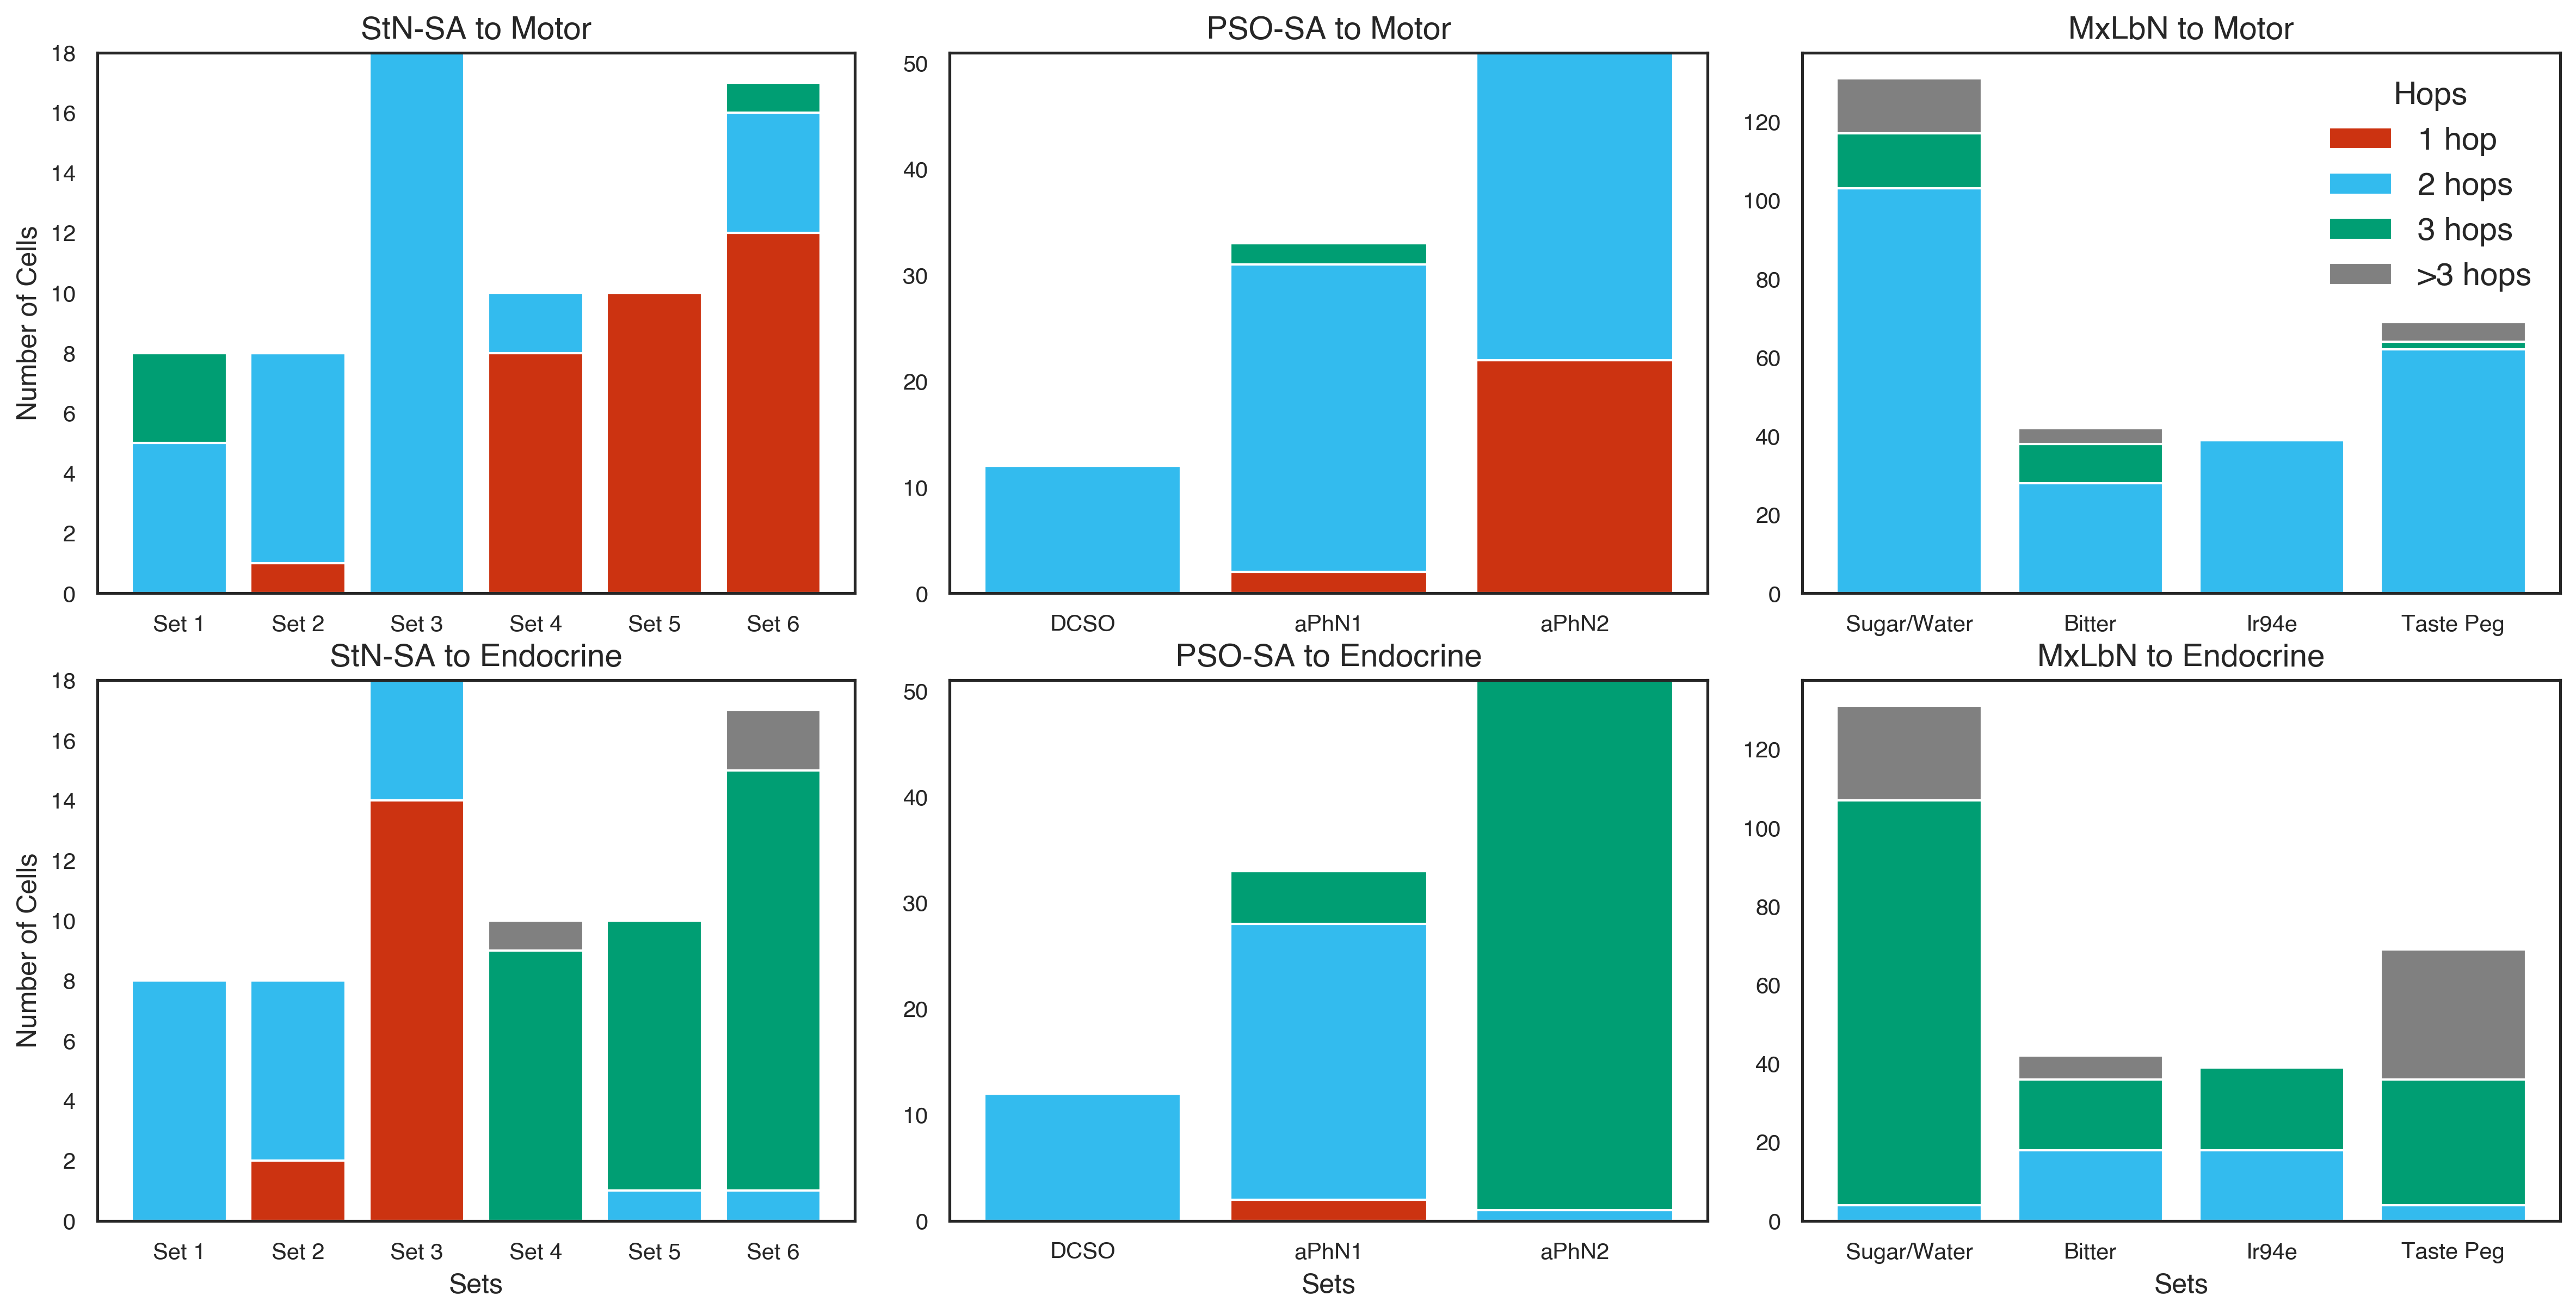

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import deque, defaultdict

# ───────────────────────────────────────────────────────────────────────────────
# 0. LOAD SHARED DATA: connectome + classification + build adjacency & super_map
# ───────────────────────────────────────────────────────────────────────────────
connections = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/'
    'YaoLabUF/YaoLab/Drosophila_brain_model/connections.csv.gz'
)
classification = pd.read_csv(
    '/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/'
    'YaoLabUF/YaoLab/Drosophila_brain_model/classification.csv.gz'
)[['root_id', 'super_class']]

edge_df = (
    connections
    .groupby(['pre_root_id', 'post_root_id'], as_index=False)
    .agg({'syn_count': 'sum'})
    .query('syn_count >= 5')
)[['pre_root_id', 'post_root_id']]

adj = defaultdict(set)
for u, v in edge_df.values:
    adj[int(u)].add(int(v))

super_map = classification.set_index('root_id')['super_class'].to_dict()

def compute_hops(src_ids, target_class):
    hop_of = {}
    for src in src_ids:
        if src not in adj:
            hop_of[src] = None
            continue
        visited = {src}
        queue = deque([(src, 0)])
        found = None
        while queue and found is None:
            node, dist = queue.popleft()
            if dist >= 3:
                continue
            for nei in adj[node]:
                if nei in visited:
                    continue
                visited.add(nei)
                nd = dist + 1
                if super_map.get(nei) == target_class:
                    found = nd
                    break
                queue.append((nei, nd))
        hop_of[src] = found
    counts = {'1':0,'2':0,'3':0,'>3':0}
    for h in hop_of.values():
        if h in (1,2,3):
            counts[str(h)] += 1
        else:
            counts['>3'] += 1
    return pd.DataFrame({
        'hop': ['1','2','3','>3'],
        'count': [counts['1'], counts['2'], counts['3'], counts['>3']]
    })

# ───────────────────────────────────────────────────────────────────────────────
# 1. DEFINE WORKFLOWS
# ───────────────────────────────────────────────────────────────────────────────
workflows = []

# StN-SA_v2 (6 sets)
stn_sets = {
    f'Set {i}': pd.read_csv(
        f'/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_{i}.csv'
    )['root_id'].astype(int)
    for i in range(1, 7)
}
workflows.append(('StN-SA', stn_sets))

# PSO (3 sets)
PSO_paths = {
    'DCSO':  '/Users/yaolab/Downloads/taste-connectome-main/aPhN-SA_v3/set_1.csv',
    'aPhN1': '/Users/yaolab/Downloads/taste-connectome-main/aPhN-SA_v3/set_2.csv',
    'aPhN2': '/Users/yaolab/Downloads/taste-connectome-main/aPhN-SA_v3/set_3.csv',
}
PSO_sets = {name: pd.read_csv(path)['root_id'].astype(int)
            for name, path in PSO_paths.items()}
workflows.append(('PSO-SA', PSO_sets))

# MxLbN GRNs (4 sets)
grn_paths = {
    'Sugar/Water': "/Users/yaolab/Downloads/sugar_water_GRNs.csv",
    'Bitter':      "/Users/yaolab/Downloads/bitter_GRNs.csv",
    'Ir94e':       "/Users/yaolab/Downloads/Ir94e_GRNs.csv",
    'Taste Peg':   "/Users/yaolab/Downloads/taste_peg_GRNs.csv",
}
grn_sets = {name: pd.read_csv(path)['root_id'].astype(int)
            for name, path in grn_paths.items()}
workflows.append(('MxLbN', grn_sets))



# ───────────────────────────────────────────────────────────────────────────────
# 2. PLOT 2×3 GRID: motor on top row, endocrine on bottom row
# ───────────────────────────────────────────────────────────────────────────────
targets = ['motor', 'endocrine']
custom_colors = ['#CC3311', '#33BBEE', '#009E73', 'gray']

n_workflows = len(workflows)
fig, axes = plt.subplots(2, n_workflows, figsize=(n_workflows * 5, 10), sharey=False)

for row, target in enumerate(targets):
    for col, (wf_name, sets_dict) in enumerate(workflows):
        ax = axes[row, col]

        # ---- compute and pivot ----
        all_df = []
        for label, ids in sets_dict.items():
            df_h = compute_hops(ids, target)
            df_h['set'] = label
            all_df.append(df_h)
        df_stack = pd.concat(all_df, ignore_index=True)
        df_stack['hop'] = pd.Categorical(df_stack['hop'], ['1','2','3','>3'], ordered=True)
        df_stack['set'] = pd.Categorical(df_stack['set'], list(sets_dict.keys()), ordered=True)
        pivot = df_stack.pivot(index='set', columns='hop', values='count').fillna(0)

        # ---- stacked bars ----
        bottom = np.zeros(len(pivot), dtype=int)
        for k, hop in enumerate(['1','2','3','>3']):
            ax.bar(
                pivot.index, pivot[hop], bottom=bottom,
                color=custom_colors[k],
                label=f"{hop} hop{'s' if hop!='1' else ''}"
            )
            bottom += pivot[hop].values

        # ---- labels & titles ----
        ax.set_title(f"{wf_name} to {target.capitalize()}", fontsize=14)
        if row == 1:
            ax.set_xlabel("Sets", fontsize=12)
        if col == 0:
            ax.set_ylabel("Number of Cells", fontsize=12)
        ax.tick_params(labelsize=10)

        # ← legend only in top-right panel
        if (row == 0) and (col == n_workflows - 1):
            ax.legend(title="Hops", frameon=False)

plt.tight_layout()
filename = f"/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/General - YaoLabUF/SVG_figs/Fig7/hops_to_{target}_subplot.svg"
# save it out at 1200×800px
fig.set_size_inches(16,8)
#fig.savefig(filename, format='svg', dpi=300, bbox_inches='tight')
plt.show()


In [9]:
#!/usr/bin/env python3
import pandas as pd
from pathlib import Path
from collections import defaultdict, deque

# ───────────────────────────────────────────────────────────────────────────────
# 0. CONFIGURATION
# ───────────────────────────────────────────────────────────────────────────────
DATA_DIR = Path.home() / "Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model"
SETS_DIR = Path.home() / "Downloads/taste-connectome-main/PhN-SA_v2"
OUT_DIR = Path.cwd() / "sensory_to_motor_paths"
MIN_SYN = 5

OUT_DIR.mkdir(exist_ok=True)

# ───────────────────────────────────────────────────────────────────────────────
# 1. LOAD FLYWIRE TABLES
# ───────────────────────────────────────────────────────────────────────────────
conns = pd.read_csv(
    DATA_DIR / "connections.csv.gz",
    usecols=["pre_root_id", "post_root_id", "syn_count"]
)
clsf = pd.read_csv(
    DATA_DIR / "classification.csv.gz",
    usecols=["root_id", "super_class"]
)

# build adjacency list for edges with ≥ MIN_SYN synapses
adj = defaultdict(set)
for pre, post, cnt in conns.itertuples(index=False):
    if cnt >= MIN_SYN:
        adj[int(pre)].add(int(post))

# lookup table for super_class
super_map = clsf.set_index("root_id")["super_class"].to_dict()


# ───────────────────────────────────────────────────────────────────────────────
# 2. HELPER: BFS to find shortest path from a sensory axon to any motor neuron
# ───────────────────────────────────────────────────────────────────────────────
def find_path_to_motor(src):
    """Return the hop-by-hop path from src to the nearest motor neuron, or None."""
    if super_map.get(src) == "motor":
        return [src]
    visited = {src}
    parent = {src: None}
    queue = deque([src])
    while queue:
        node = queue.popleft()
        for nei in adj[node]:
            if nei in visited:
                continue
            visited.add(nei)
            parent[nei] = node
            if super_map.get(nei) == "motor":
                # reconstruct path backward
                path = [nei]
                while parent[path[-1]] is not None:
                    path.append(parent[path[-1]])
                return list(reversed(path))
            queue.append(nei)
    return None


# ───────────────────────────────────────────────────────────────────────────────
# 3. PROCESS EACH StN-SA SET
# ───────────────────────────────────────────────────────────────────────────────
for i in range(1, 7):
    set_name = f"Set_{i}"
    sensory = pd.read_csv(SETS_DIR / f"set_{i}.csv")["root_id"].astype(int).unique()

    # 3a) find all paths and track maximum length
    paths = {}
    max_len = 0
    for src in sensory:
        p = find_path_to_motor(src)
        paths[src] = p
        if p is not None:
            max_len = max(max_len, len(p))

    # 3b) build a DataFrame with fixed columns ['src','path_found','hop_0',...,'hop_{max_len-1}']
    cols = ["src", "path_found"] + [f"hop_{h}" for h in range(max_len)]
    rows = []
    for src, p in paths.items():
        row = [src, bool(p)]
        if p is None:
            row += [""] * max_len
        else:
            # pad p to length max_len with empty strings
            row += p + [""] * (max_len - len(p))
        rows.append(row)

    df_paths = pd.DataFrame(rows, columns=cols)

    # ───────────────────────────────────────────────────────────────────────────
    # 4. SAVE TO CSV
    # ───────────────────────────────────────────────────────────────────────────
    out_csv = OUT_DIR / f"{set_name}_sensory_to_motor_paths.csv"
    df_paths.to_csv(out_csv, index=False)
    print(f"Wrote {len(df_paths)} rows → {out_csv}")


Wrote 8 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/Set_1_sensory_to_motor_paths.csv
Wrote 8 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/Set_2_sensory_to_motor_paths.csv
Wrote 18 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/Set_3_sensory_to_motor_paths.csv
Wrote 10 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/Set_4_sensory_to_motor_paths.csv
Wrote 10 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/Set_5_sensory_to_motor_paths.csv
Wrote 17 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/Set_6_sensory_to_motor_paths.csv


In [10]:
#!/usr/bin/env python3
import pandas as pd
from pathlib import Path
from collections import defaultdict, deque

# ───────────────────────────────────────────────────────────────────────────────
# 0. CONFIGURATION
# ───────────────────────────────────────────────────────────────────────────────
DATA_DIR = Path.home() / "Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model"
SETS_DIR = Path.home() / "Downloads/taste-connectome-main/PhN-SA_v2"
OUT_DIR = Path.cwd() / "sensory_to_motor_paths"
MIN_SYN = 5

OUT_DIR.mkdir(exist_ok=True)

# ───────────────────────────────────────────────────────────────────────────────
# 1. LOAD FLYWIRE TABLES
# ───────────────────────────────────────────────────────────────────────────────
conns = pd.read_csv(
    DATA_DIR / "connections.csv.gz",
    usecols=["pre_root_id", "post_root_id", "syn_count"]
)
clsf = pd.read_csv(
    DATA_DIR / "classification.csv.gz",
    usecols=["root_id", "super_class"]
)

# build adjacency list for edges with ≥ MIN_SYN synapses
adj = defaultdict(set)
for pre, post, cnt in conns.itertuples(index=False):
    if cnt >= MIN_SYN:
        adj[int(pre)].add(int(post))

# lookup table for super_class
super_map = clsf.set_index("root_id")["super_class"].to_dict()


# ───────────────────────────────────────────────────────────────────────────────
# 2. HELPER: find all shortest paths from src to every motor neuron
# ───────────────────────────────────────────────────────────────────────────────
def find_all_motor_paths(src):
    """Return dict motor_id → list of all shortest paths (each path a list of nodes)."""
    parents = defaultdict(list)
    dist = {src: 0}
    queue = deque([src])
    found_motor_level = None
    motors = set()

    while queue:
        node = queue.popleft()
        d = dist[node]
        if found_motor_level is not None and d >= found_motor_level:
            continue
        for nei in adj[node]:
            nd = d + 1
            if nei not in dist:
                dist[nei] = nd
                queue.append(nei)
            if dist[nei] == nd:
                parents[nei].append(node)
            if super_map.get(nei) == "motor":
                motors.add(nei)
                if found_motor_level is None or nd < found_motor_level:
                    found_motor_level = nd

    if not motors:
        return {}

    def build_paths(node):
        if node == src:
            return [[src]]
        paths = []
        for p in parents[node]:
            for path in build_paths(p):
                paths.append(path + [node])
        return paths

    all_paths = {}
    for m in motors:
        all_paths[m] = build_paths(m)
    return all_paths


# ───────────────────────────────────────────────────────────────────────────────
# 3. PROCESS EACH StN-SA SET
# ───────────────────────────────────────────────────────────────────────────────
for i in range(1, 7):
    set_name = f"Set_{i}"
    sensory = pd.read_csv(SETS_DIR / f"set_{i}.csv")["root_id"].astype(int).unique()

    # collect raw records: (src, motor, path_list)
    raw = []
    for src in sensory:
        motor_paths = find_all_motor_paths(src)
        if not motor_paths:
            raw.append((src, None, []))
        else:
            for motor_id, paths in motor_paths.items():
                for path in paths:
                    raw.append((src, motor_id, path))

    # determine max path length across all records
    max_len = max((len(path) for _, _, path in raw), default=0)

    # build DataFrame rows with hop_ columns
    cols = ["src", "motor", "path_found"] + [f"hop_{h}" for h in range(max_len)]
    rows = []
    for src, motor_id, path in raw:
        row = {
            "src": src,
            "motor": motor_id if motor_id is not None else "",
            "path_found": bool(path)
        }
        # pad path to max_len
        for h in range(max_len):
            row[f"hop_{h}"] = path[h] if h < len(path) else ""
        rows.append(row)

    df_paths = pd.DataFrame(rows, columns=cols)

    # save CSV
    out_csv = OUT_DIR / f"{set_name}_sensory_to_motor_paths.csv"
    df_paths.to_csv(out_csv, index=False)
    print(f"Wrote {len(df_paths)} rows → {out_csv}")


Wrote 264 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/Set_1_sensory_to_motor_paths.csv
Wrote 226 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/Set_2_sensory_to_motor_paths.csv
Wrote 510 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/Set_3_sensory_to_motor_paths.csv
Wrote 162 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/Set_4_sensory_to_motor_paths.csv
Wrote 32 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/Set_5_sensory_to_motor_paths.csv
Wrote 98 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/Set_6_sensory_to_motor_paths.csv


In [11]:
#!/usr/bin/env python3
import pandas as pd
from pathlib import Path
from collections import defaultdict, deque

# ───────────────────────────────────────────────────────────────────────────────
# 0. CONFIGURATION
# ───────────────────────────────────────────────────────────────────────────────
DATA_DIR = Path.home() / "Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model"
SETS_DIR = Path.home() / "Downloads/taste-connectome-main/PhN-SA_v2"
OUT_DIR = Path.cwd() / "sensory_to_motor_paths"
MIN_SYN = 5

OUT_DIR.mkdir(exist_ok=True)

# ───────────────────────────────────────────────────────────────────────────────
# 1. LOAD FLYWIRE TABLES
# ───────────────────────────────────────────────────────────────────────────────
conns = pd.read_csv(
    DATA_DIR / "connections.csv.gz",
    usecols=["pre_root_id", "post_root_id", "syn_count"]
)
clsf = pd.read_csv(
    DATA_DIR / "classification.csv.gz",
    usecols=["root_id", "super_class"]
)

# build adjacency list for edges with ≥ MIN_SYN synapses
adj = defaultdict(set)
for pre, post, cnt in conns.itertuples(index=False):
    if cnt >= MIN_SYN:
        adj[int(pre)].add(int(post))

# lookup table for super_class
super_map = clsf.set_index("root_id")["super_class"].to_dict()


# ───────────────────────────────────────────────────────────────────────────────
# 2. HELPER: find all shortest paths from src to every motor neuron
# ───────────────────────────────────────────────────────────────────────────────
def find_all_motor_paths(src):
    """Return dict motor_id → list of all shortest paths (each path a list of nodes)."""
    parents = defaultdict(list)
    dist = {src: 0}
    queue = deque([src])
    found_motor_level = None
    motors = set()

    while queue:
        node = queue.popleft()
        d = dist[node]
        if found_motor_level is not None and d >= found_motor_level:
            continue
        for nei in adj[node]:
            nd = d + 1
            if nei not in dist:
                dist[nei] = nd
                queue.append(nei)
            if dist[nei] == nd:
                parents[nei].append(node)
            if super_map.get(nei) == "motor":
                motors.add(nei)
                if found_motor_level is None or nd < found_motor_level:
                    found_motor_level = nd

    if not motors:
        return {}

    def build_paths(node):
        if node == src:
            return [[src]]
        paths = []
        for p in parents[node]:
            for path in build_paths(p):
                paths.append(path + [node])
        return paths

    all_paths = {}
    for m in motors:
        all_paths[m] = build_paths(m)
    return all_paths


# ───────────────────────────────────────────────────────────────────────────────
# 3. PROCESS EACH StN-SA SET
# ───────────────────────────────────────────────────────────────────────────────
for i in range(1, 7):
    set_name = f"Set_{i}"
    sensory = pd.read_csv(SETS_DIR / f"set_{i}.csv")["root_id"].astype(int).unique()

    # collect raw records: (src, motor, path_list)
    raw = []
    for src in sensory:
        motor_paths = find_all_motor_paths(src)
        if not motor_paths:
            raw.append((src, None, []))
        else:
            for motor_id, paths in motor_paths.items():
                for path in paths:
                    raw.append((src, motor_id, path))

    # determine max path length across all records
    max_len = max((len(path) for _, _, path in raw), default=0)

    # build DataFrame rows with hop_ columns
    cols = ["src", "motor", "path_found"] + [f"hop_{h}" for h in range(max_len)]
    rows = []
    for src, motor_id, path in raw:
        row = {
            "src": src,
            "motor": motor_id if motor_id is not None else "",
            "path_found": bool(path)
        }
        # pad path to max_len
        for h in range(max_len):
            row[f"hop_{h}"] = path[h] if h < len(path) else ""
        rows.append(row)

    df_paths = pd.DataFrame(rows, columns=cols)

    # save CSV
    out_csv = OUT_DIR / f"{set_name}_sensory_to_motor_paths.csv"
    df_paths.to_csv(out_csv, index=False)
    print(f"Wrote {len(df_paths)} rows → {out_csv}")


Wrote 264 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/Set_1_sensory_to_motor_paths.csv
Wrote 226 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/Set_2_sensory_to_motor_paths.csv
Wrote 510 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/Set_3_sensory_to_motor_paths.csv
Wrote 162 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/Set_4_sensory_to_motor_paths.csv
Wrote 32 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/Set_5_sensory_to_motor_paths.csv
Wrote 98 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/Set_6_sensory_to_motor_paths.csv


In [12]:
#!/usr/bin/env python3
import re
import pandas as pd
from pathlib import Path
from collections import defaultdict, deque

# ───────────────────────────────────────────────────────────────────────────────
# 0. CONFIGURATION
# ───────────────────────────────────────────────────────────────────────────────
DATA_DIR = Path.home() / "Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model"
OUT_DIR  = Path.cwd() / "sensory_to_motor_paths"
MIN_SYN  = 5

OUT_DIR.mkdir(exist_ok=True, parents=True)

# ───────────────────────────────────────────────────────────────────────────────
# 1. LOAD FLYWIRE TABLES & BUILD ADJACENCY
# ───────────────────────────────────────────────────────────────────────────────
conns = pd.read_csv(
    DATA_DIR / "connections.csv.gz",
    usecols=["pre_root_id", "post_root_id", "syn_count"]
)
clsf = pd.read_csv(
    DATA_DIR / "classification.csv.gz",
    usecols=["root_id", "super_class"]
)

adj = defaultdict(set)
for pre, post, cnt in conns.itertuples(index=False):
    if cnt >= MIN_SYN:
        adj[int(pre)].add(int(post))

super_map = clsf.set_index("root_id")["super_class"].to_dict()

# ───────────────────────────────────────────────────────────────────────────────
# 2. HELPER: FIND ALL SHORTEST PATHS TO MOTOR NEURONS
# ───────────────────────────────────────────────────────────────────────────────
def find_all_motor_paths(src):
    parents       = defaultdict(list)
    dist          = {src: 0}
    queue         = deque([src])
    found_level   = None
    motors        = set()

    while queue:
        node = queue.popleft()
        d    = dist[node]
        if found_level is not None and d >= found_level:
            continue
        for nei in adj[node]:
            nd = d + 1
            if nei not in dist:
                dist[nei] = nd
                queue.append(nei)
            if dist[nei] == nd:
                parents[nei].append(node)
            if super_map.get(nei) == "motor":
                motors.add(nei)
                if found_level is None or nd < found_level:
                    found_level = nd

    if not motors:
        return {}

    def build_paths(node):
        if node == src:
            return [[src]]
        paths = []
        for p in parents[node]:
            for path in build_paths(p):
                paths.append(path + [node])
        return paths

    return {m: build_paths(m) for m in motors}

# ───────────────────────────────────────────────────────────────────────────────
# 3. DEFINE WORKFLOWS & SETS (with your correct file paths)
# ───────────────────────────────────────────────────────────────────────────────
workflows = []

# (a) StN-SA_v2 (6 sets)
stn_sets = {
    f"Set {i}": pd.read_csv(
        f"/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_{i}.csv"
    )["root_id"].astype(int)
    for i in range(1, 7)
}
workflows.append(("StN-SA", stn_sets))

# (b) PSO-SA (3 sets)
PSO_paths = {
    "DCSO":  "/Users/yaolab/Downloads/taste-connectome-main/aPhN-SA_v3/set_1.csv",
    "aPhN1": "/Users/yaolab/Downloads/taste-connectome-main/aPhN-SA_v3/set_2.csv",
    "aPhN2": "/Users/yaolab/Downloads/taste-connectome-main/aPhN-SA_v3/set_3.csv",
}
PSO_sets = {name: pd.read_csv(path)["root_id"].astype(int) for name, path in PSO_paths.items()}
workflows.append(("PSO-SA", PSO_sets))

# (c) MxLbN GRNs (4 sets)
grn_paths = {
    "Sugar/Water": "/Users/yaolab/Downloads/sugar_water_GRNs.csv",
    "Bitter":      "/Users/yaolab/Downloads/bitter_GRNs.csv",
    "Ir94e":       "/Users/yaolab/Downloads/Ir94e_GRNs.csv",
    "Taste Peg":   "/Users/yaolab/Downloads/taste_peg_GRNs.csv",
}
grn_sets = {name: pd.read_csv(path)["root_id"].astype(int) for name, path in grn_paths.items()}
workflows.append(("MxLbN", grn_sets))

# ───────────────────────────────────────────────────────────────────────────────
# 4. PROCESS EACH WORKFLOW & SET
# ───────────────────────────────────────────────────────────────────────────────
def sanitize(name: str) -> str:
    # replace any non-alphanumeric char with underscore
    return re.sub(r'[^0-9A-Za-z]+', '_', name).strip('_')

for wf_name, sets_dict in workflows:
    wf_safe = sanitize(wf_name)
    for set_label, ids in sets_dict.items():
        set_safe = sanitize(set_label)
        raw = []
        for src in ids.unique():
            motor_paths = find_all_motor_paths(src)
            if not motor_paths:
                raw.append((src, None, []))
            else:
                for motor_id, paths in motor_paths.items():
                    for path in paths:
                        raw.append((src, motor_id, path))

        max_len = max((len(p) for _,_,p in raw), default=0)
        cols    = ["src", "motor", "path_found"] + [f"hop_{h}" for h in range(max_len)]
        rows    = []
        for src, motor_id, path in raw:
            row = {"src": src, "motor": motor_id or "", "path_found": bool(path)}
            for h in range(max_len):
                row[f"hop_{h}"] = path[h] if h < len(path) else ""
            rows.append(row)

        df_paths = pd.DataFrame(rows, columns=cols)
        out_csv  = OUT_DIR / f"{wf_safe}_{set_safe}_paths.csv"
        df_paths.to_csv(out_csv, index=False)
        print(f"Wrote {len(df_paths)} rows → {out_csv}")


Wrote 264 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_1_paths.csv
Wrote 226 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_2_paths.csv
Wrote 510 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_3_paths.csv
Wrote 162 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_4_paths.csv
Wrote 32 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_5_paths.csv
Wrote 98 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_6_paths.csv
Wrote 547 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_m

In [13]:
# ───────────────────────────────────────────────────────────────────────────────
# 4. PROCESS EACH WORKFLOW & EXPORT ONLY MOTOR PATHS UP TO 3 HOPS
# ───────────────────────────────────────────────────────────────────────────────
MAX_HOPS = 3

def find_motor_paths_upto_n(src, max_hops):
    """
    BFS out to max_hops, record all *shortest* paths ending in a motor neuron
    of length ≤ max_hops.
    Returns dict: motor_id → [path1, path2, ...]
    """
    parents = defaultdict(list)
    dist    = {src: 0}
    queue   = deque([src])
    motors  = set()

    # 1) BFS to build parent pointers & record any motors at <= max_hops
    while queue:
        node = queue.popleft()
        d    = dist[node]
        if d >= max_hops:
            continue
        for nei in adj[node]:
            nd = d + 1
            if nd > max_hops:
                continue
            # first time we see nei at distance nd
            if nei not in dist:
                dist[nei] = nd
                queue.append(nei)
            # if this is also the shortest distance, record parent
            if dist[nei] == nd:
                parents[nei].append(node)
            # if it's a motor, mark it
            if super_map.get(nei) == "motor":
                motors.add(nei)

    # 2) no motors → return empty
    if not motors:
        return {}

    # 3) recursively reconstruct all shortest paths for each motor
    def build_paths(node):
        if node == src:
            return [[src]]
        paths = []
        for p in parents[node]:
            for path in build_paths(p):
                paths.append(path + [node])
        return paths

    return {m: build_paths(m) for m in motors}


for wf_name, sets_dict in workflows:
    wf_safe = sanitize(wf_name)
    for set_label, ids in sets_dict.items():
        set_safe = sanitize(set_label)
        raw = []

        # gather only motor‐ending paths of length ≤ MAX_HOPS
        for src in ids.unique():
            motor_paths = find_motor_paths_upto_n(src, MAX_HOPS)
            for motor_id, paths in motor_paths.items():
                for path in paths:
                    raw.append((src, motor_id, path))

        # if nothing found, you can optionally skip or write an empty file
        if not raw:
            print(f"No motor paths ≤{MAX_HOPS} hops for {wf_name} / {set_label}")
            continue

        # find the widest path to set column count
        max_len = max(len(p) for _,_,p in raw)

        cols = ["src", "motor", "path_found"] + [f"hop_{i}" for i in range(max_len)]
        rows = []
        for src, motor_id, path in raw:
            row = {
                "src":        src,
                "motor":      motor_id,
                "path_found": True
            }
            for i in range(max_len):
                row[f"hop_{i}"] = path[i] if i < len(path) else ""
            rows.append(row)

        df = pd.DataFrame(rows, columns=cols)
        out_csv = OUT_DIR / f"{wf_safe}_{set_safe}_motor_paths_up_to_{MAX_HOPS}hops.csv"
        df.to_csv(out_csv, index=False)
        print(f"Wrote {len(df)} rows → {out_csv}")


Wrote 692 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_1_motor_paths_up_to_3hops.csv
Wrote 5387 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_2_motor_paths_up_to_3hops.csv
Wrote 15289 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_3_motor_paths_up_to_3hops.csv
Wrote 10990 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_4_motor_paths_up_to_3hops.csv
Wrote 7365 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_5_motor_paths_up_to_3hops.csv
Wrote 9119 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_6_motor_paths_up_to_3hops.c

In [14]:
# ───────────────────────────────────────────────────────────────────────────────
# 4. PROCESS EACH WORKFLOW & EXPORT ONLY MOTOR PATHS UP TO 2 HOPS
# ───────────────────────────────────────────────────────────────────────────────
MAX_HOPS = 2

def find_motor_paths_upto_n(src, max_hops):
    """
    BFS out to max_hops, record all *shortest* paths ending in a motor neuron
    of length ≤ max_hops.
    Returns dict: motor_id → [path1, path2, ...]
    """
    parents = defaultdict(list)
    dist    = {src: 0}
    queue   = deque([src])
    motors  = set()

    # 1) BFS to build parent pointers & record any motors at <= max_hops
    while queue:
        node = queue.popleft()
        d    = dist[node]
        if d >= max_hops:
            continue
        for nei in adj[node]:
            nd = d + 1
            if nd > max_hops:
                continue
            # first time we see nei at distance nd
            if nei not in dist:
                dist[nei] = nd
                queue.append(nei)
            # if this is also the shortest distance, record parent
            if dist[nei] == nd:
                parents[nei].append(node)
            # if it's a motor, mark it
            if super_map.get(nei) == "motor":
                motors.add(nei)

    # 2) no motors → return empty
    if not motors:
        return {}

    # 3) recursively reconstruct all shortest paths for each motor
    def build_paths(node):
        if node == src:
            return [[src]]
        paths = []
        for p in parents[node]:
            for path in build_paths(p):
                paths.append(path + [node])
        return paths

    return {m: build_paths(m) for m in motors}


for wf_name, sets_dict in workflows:
    wf_safe = sanitize(wf_name)
    for set_label, ids in sets_dict.items():
        set_safe = sanitize(set_label)
        raw = []

        # gather only motor‐ending paths of length ≤ MAX_HOPS
        for src in ids.unique():
            motor_paths = find_motor_paths_upto_n(src, MAX_HOPS)
            for motor_id, paths in motor_paths.items():
                for path in paths:
                    raw.append((src, motor_id, path))

        # if nothing found, you can optionally skip or write an empty file
        if not raw:
            print(f"No motor paths ≤{MAX_HOPS} hops for {wf_name} / {set_label}")
            continue

        # find the widest path to set column count
        max_len = max(len(p) for _,_,p in raw)

        cols = ["src", "motor", "path_found"] + [f"hop_{i}" for i in range(max_len)]
        rows = []
        for src, motor_id, path in raw:
            row = {
                "src":        src,
                "motor":      motor_id,
                "path_found": True
            }
            for i in range(max_len):
                row[f"hop_{i}"] = path[i] if i < len(path) else ""
            rows.append(row)

        df = pd.DataFrame(rows, columns=cols)
        out_csv = OUT_DIR / f"{wf_safe}_{set_safe}_motor_paths_up_to_{MAX_HOPS}hops.csv"
        df.to_csv(out_csv, index=False)
        print(f"Wrote {len(df)} rows → {out_csv}")


Wrote 4 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_1_motor_paths_up_to_2hops.csv
Wrote 258 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_2_motor_paths_up_to_2hops.csv
Wrote 510 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_3_motor_paths_up_to_2hops.csv
Wrote 969 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_4_motor_paths_up_to_2hops.csv
Wrote 416 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_5_motor_paths_up_to_2hops.csv
Wrote 683 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_6_motor_paths_up_to_2hops.csv
Wrote 

In [15]:
# ───────────────────────────────────────────────────────────────────────────────
# 4. PROCESS EACH WORKFLOW & EXPORT ONLY MOTOR PATHS UP TO 2 HOPS,
#    WITH ANNOTATED hop_1_superclass AND SORTED BY HOP DEPTH
# ───────────────────────────────────────────────────────────────────────────────
MAX_HOPS = 2

def find_motor_paths_upto_n(src, max_hops):
    parents = defaultdict(list)
    dist    = {src: 0}
    queue   = deque([src])
    motors  = set()

    # BFS up to max_hops, record parents & motor hits
    while queue:
        node = queue.popleft()
        d    = dist[node]
        if d >= max_hops:
            continue
        for nei in adj[node]:
            nd = d + 1
            if nd > max_hops:
                continue
            if nei not in dist:
                dist[nei] = nd
                queue.append(nei)
            if dist[nei] == nd:
                parents[nei].append(node)
            if super_map.get(nei) == "motor":
                motors.add(nei)

    if not motors:
        return {}

    def build_paths(node):
        if node == src:
            return [[src]]
        paths = []
        for p in parents[node]:
            for path in build_paths(p):
                paths.append(path + [node])
        return paths

    return {m: build_paths(m) for m in motors}


for wf_name, sets_dict in workflows:
    wf_safe = sanitize(wf_name)
    for set_label, ids in sets_dict.items():
        set_safe = sanitize(set_label)
        raw = []

        # gather only motor‐ending paths of length ≤ MAX_HOPS
        for src in ids.unique():
            for motor_id, paths in find_motor_paths_upto_n(src, MAX_HOPS).items():
                for path in paths:
                    raw.append((src, motor_id, path))

        if not raw:
            print(f"No motor paths ≤{MAX_HOPS} hops for {wf_name} / {set_label}")
            continue

        # determine max number of hops seen
        max_len = max(len(p) for _,_,p in raw)  # number of nodes
        # we'll have hop_0 ... hop_{max_len-1}
        cols = ["src","motor","path_found"] + [f"hop_{i}" for i in range(max_len)]
        rows = []
        for src, motor_id, path in raw:
            row = {"src":src, "motor":motor_id, "path_found":True}
            for i in range(max_len):
                row[f"hop_{i}"] = path[i] if i < len(path) else ""
            rows.append(row)

        df = pd.DataFrame(rows, columns=cols)

        # annotate hop_1 superclass
        df["hop_1_superclass"] = df["hop_1"].map(super_map).fillna("unknown")

        # compute actual number of hops (excluding hop_0)
        hop_cols = sorted([c for c in df.columns if c.startswith("hop_")],
                          key=lambda c: int(c.split("_")[1]))
        # count non-empty in hop_1 ... hop_{max_len-1}
        df["num_hops"] = df[hop_cols[1:]].ne("").sum(axis=1)

        # sort so that num_hops=1 first, then 2, etc., and reset index
        df = df.sort_values("num_hops").reset_index(drop=True)

        # drop helper column if you like:
        df.drop(columns=["num_hops"], inplace=True)

        # save the full annotated & sorted table
        out_fn = OUT_DIR / f"{wf_safe}_{set_safe}_motor_paths_up_to_{MAX_HOPS}hops_annotated.csv"
        df.to_csv(out_fn, index=False)
        print(f"Wrote full annotated & sorted table ({len(df)} rows) → {out_fn}")


Wrote full annotated & sorted table (4 rows) → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_1_motor_paths_up_to_2hops_annotated.csv
Wrote full annotated & sorted table (258 rows) → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_2_motor_paths_up_to_2hops_annotated.csv
Wrote full annotated & sorted table (510 rows) → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_3_motor_paths_up_to_2hops_annotated.csv
Wrote full annotated & sorted table (969 rows) → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_4_motor_paths_up_to_2hops_annotated.csv
Wrote full annotated & sorted table (416 rows) → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_5_

In [16]:
# ───────────────────────────────────────────────────────────────────────────────
# 4. PROCESS EACH WORKFLOW & EXPORT ONLY MOTOR PATHS UP TO 2 HOPS,
#    WITH hop_1_superclass BETWEEN hop_1 & hop_2 AND SORTED
# ───────────────────────────────────────────────────────────────────────────────
MAX_HOPS = 2

def find_motor_paths_upto_n(src, max_hops):
    parents = defaultdict(list)
    dist    = {src: 0}
    queue   = deque([src])
    motors  = set()

    while queue:
        node = queue.popleft()
        d    = dist[node]
        if d >= max_hops:
            continue
        for nei in adj[node]:
            nd = d + 1
            if nd > max_hops:
                continue
            if nei not in dist:
                dist[nei] = nd
                queue.append(nei)
            if dist[nei] == nd:
                parents[nei].append(node)
            if super_map.get(nei) == "motor":
                motors.add(nei)

    if not motors:
        return {}

    def build_paths(node):
        if node == src:
            return [[src]]
        paths = []
        for p in parents[node]:
            for path in build_paths(p):
                paths.append(path + [node])
        return paths

    return {m: build_paths(m) for m in motors}


for wf_name, sets_dict in workflows:
    wf_safe = sanitize(wf_name)
    for set_label, ids in sets_dict.items():
        set_safe = sanitize(set_label)
        raw = []

        for src in ids.unique():
            for motor_id, paths in find_motor_paths_upto_n(src, MAX_HOPS).items():
                for path in paths:
                    raw.append((src, motor_id, path))

        if not raw:
            print(f"No motor paths ≤{MAX_HOPS} hops for {wf_name} / {set_label}")
            continue

        # build the basic DataFrame
        max_len = max(len(p) for _,_,p in raw)
        rows = []
        for src, motor_id, path in raw:
            rows.append({
                "src":        src,
                "motor":      motor_id,
                "path_found": True,
                "hop_0":      path[0],
                "hop_1":      path[1] if len(path)>1 else "",
                "hop_2":      path[2] if len(path)>2 else ""
            })
        df = pd.DataFrame(rows)

        # annotate hop_1 superclass
        df["hop_1_superclass"] = df["hop_1"].map(super_map).fillna("unknown")

        # compute hop-count (1 or 2)
        df["num_hops"] = df[["hop_1","hop_2"]].ne("").sum(axis=1)

        # sort by depth then superclass then hop_1
        df = (
            df.sort_values(
                ["num_hops","hop_1_superclass","hop_1"],
                ascending=[True,True,True]
            )
            .reset_index(drop=True)
        )

        # now pick columns in the order you want (num_hops is simply omitted)
        df = df[
            ["src","motor","path_found",
             "hop_0","hop_1","hop_1_superclass","hop_2"]
        ]

        # save
        out_fn = OUT_DIR / f"{wf_safe}_{set_safe}_motor_paths_up_to_{MAX_HOPS}hops_annotated.csv"
        df.to_csv(out_fn, index=False)
        print(f"Wrote full annotated & sorted table → {out_fn}")


Wrote full annotated & sorted table → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_1_motor_paths_up_to_2hops_annotated.csv
Wrote full annotated & sorted table → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_2_motor_paths_up_to_2hops_annotated.csv
Wrote full annotated & sorted table → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_3_motor_paths_up_to_2hops_annotated.csv
Wrote full annotated & sorted table → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_4_motor_paths_up_to_2hops_annotated.csv
Wrote full annotated & sorted table → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_5_motor_paths_up_to_2hops_annotated.csv
Wrote full anno

In [17]:
# ───────────────────────────────────────────────────────────────────────────────
# 4. PROCESS EACH WORKFLOW & EXPORT ONLY MOTOR PATHS UP TO 2 HOPS,
#    WITH hop_1_superclass AND hop_1_origin, SORTED & COLUMN-ORDERED
# ───────────────────────────────────────────────────────────────────────────────
MAX_HOPS = 2

# 0) Build a lookup of every root_id → list of (workflow,set) it belongs to
origin_map = {}
for wf_name, sets_dict in workflows:
    for set_label, ids in sets_dict.items():
        for rid in ids.unique():
            origin_map.setdefault(rid, []).append(f"{wf_name}:{set_label}")

def find_motor_paths_upto_n(src, max_hops):
    parents = defaultdict(list)
    dist    = {src: 0}
    queue   = deque([src])
    motors  = set()
    # BFS up to max_hops
    while queue:
        node = queue.popleft()
        d    = dist[node]
        if d >= max_hops:
            continue
        for nei in adj[node]:
            nd = d + 1
            if nd > max_hops:
                continue
            if nei not in dist:
                dist[nei] = nd
                queue.append(nei)
            if dist[nei] == nd:
                parents[nei].append(node)
            if super_map.get(nei) == "motor":
                motors.add(nei)
    if not motors:
        return {}
    def build_paths(node):
        if node == src:
            return [[src]]
        paths = []
        for p in parents[node]:
            for path in build_paths(p):
                paths.append(path + [node])
        return paths
    return {m: build_paths(m) for m in motors}

for wf_name, sets_dict in workflows:
    wf_safe = sanitize(wf_name)
    for set_label, ids in sets_dict.items():
        set_safe = sanitize(set_label)
        raw = []
        # collect all motor-ending paths ≤ MAX_HOPS
        for src in ids.unique():
            for motor_id, paths in find_motor_paths_upto_n(src, MAX_HOPS).items():
                for path in paths:
                    raw.append((src, motor_id, path))
        if not raw:
            print(f"No motor paths ≤{MAX_HOPS} hops for {wf_name} / {set_label}")
            continue

        # build DataFrame rows
        rows = []
        for src, motor_id, path in raw:
            rows.append({
                "src":            src,
                "motor":          motor_id,
                "path_found":     True,
                "hop_0":          path[0],
                "hop_1":          path[1] if len(path) > 1 else "",
                "hop_2":          path[2] if len(path) > 2 else ""
            })
        df = pd.DataFrame(rows)

        # annotate hop_1 superclass
        df["hop_1_superclass"] = df["hop_1"].map(super_map).fillna("unknown")

        # annotate hop_1 origin membership
        df["hop_1_origin"] = df["hop_1"].map(lambda x:
            ";".join(origin_map.get(x, []))
        )

        # compute hop depth (1 or 2)
        df["num_hops"] = df[["hop_1","hop_2"]].ne("").sum(axis=1)

        # sort by depth, then superclass, then hop_1, then origin
        df = df.sort_values(
            ["num_hops","hop_1_superclass","hop_1","hop_1_origin"],
            ascending=[True,True,True,True]
        ).reset_index(drop=True)

        # select columns in desired order
        df = df[[
            "src","motor","path_found",
            "hop_0","hop_1","hop_1_superclass","hop_1_origin","hop_2"
        ]]

        # save annotated & sorted table
        out_fn = OUT_DIR / f"{wf_safe}_{set_safe}_motor_paths_up_to_{MAX_HOPS}hops_annotated.csv"
        df.to_csv(out_fn, index=False)
        print(f"Wrote {len(df)} rows → {out_fn}")


Wrote 4 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_1_motor_paths_up_to_2hops_annotated.csv
Wrote 258 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_2_motor_paths_up_to_2hops_annotated.csv
Wrote 510 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_3_motor_paths_up_to_2hops_annotated.csv
Wrote 969 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_4_motor_paths_up_to_2hops_annotated.csv
Wrote 416 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_5_motor_paths_up_to_2hops_annotated.csv
Wrote 683 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_pat

In [18]:
#!/usr/bin/env python3
import pandas as pd
from collections import defaultdict, deque
from pathlib import Path

# ───────────────────────────────────────────────────────────────────────────────
# CONFIG
# ───────────────────────────────────────────────────────────────────────────────
DATA_DIR = Path.home() / "Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model"
SETS_DIR = Path.home() / "Downloads/taste-connectome-main/PhN-SA_v2"
OUT_DIR  = Path.cwd() / "sensory_to_motor_paths"
MAX_HOPS = 2

# ───────────────────────────────────────────────────────────────────────────────
# A) Reload classification to get both super_class and class ("nerve")
# ───────────────────────────────────────────────────────────────────────────────
classification_full = pd.read_csv(
    DATA_DIR / "classification.csv.gz",
    usecols=["root_id", "super_class", "class", "nerve"]
)
super_map = classification_full.set_index("root_id")["super_class"].to_dict()
nerve_map = classification_full.set_index("root_id")["nerve"].to_dict()

# ───────────────────────────────────────────────────────────────────────────────
# B) Build origin_map: root_id → [workflow:set,...]
# ───────────────────────────────────────────────────────────────────────────────
origin_map = {}
for wf_name, sets_dict in workflows:
    for set_label, ids in sets_dict.items():
        for rid in ids.unique():
            origin_map.setdefault(rid, []).append(f"{wf_name}:{set_label}")

# ───────────────────────────────────────────────────────────────────────────────
# C) BFS helper: find all shortest motor-ending paths ≤ MAX_HOPS
# ───────────────────────────────────────────────────────────────────────────────
def find_motor_paths_upto_n(src, max_hops):
    parents = defaultdict(list)
    dist    = {src: 0}
    queue   = deque([src])
    motors  = set()

    while queue:
        node = queue.popleft()
        d    = dist[node]
        if d >= max_hops:
            continue
        for nei in adj[node]:
            nd = d + 1
            if nd > max_hops:
                continue
            if nei not in dist:
                dist[nei] = nd
                queue.append(nei)
            if dist[nei] == nd:
                parents[nei].append(node)
            if super_map.get(nei) == "motor":
                motors.add(nei)

    if not motors:
        return {}

    def build_paths(node):
        if node == src:
            return [[src]]
        paths = []
        for p in parents[node]:
            for sub in build_paths(p):
                paths.append(sub + [node])
        return paths

    return {m: build_paths(m) for m in motors}

# ───────────────────────────────────────────────────────────────────────────────
# D) Process each StN-SA set, annotate hop_1 and hop_2, sort, and save
# ───────────────────────────────────────────────────────────────────────────────
for wf_name, sets_dict in workflows:
    wf_safe = sanitize(wf_name)
    for set_label, ids in sets_dict.items():
        set_safe = sanitize(set_label)
        raw = []

        # collect all paths of length ≤ MAX_HOPS ending in motor
        for src in ids.unique():
            for motor_id, paths in find_motor_paths_upto_n(src, MAX_HOPS).items():
                for path in paths:
                    raw.append((src, motor_id, path))

        if not raw:
            print(f"No motor paths ≤{MAX_HOPS} hops for {wf_name}/{set_label}")
            continue

        # build DataFrame rows
        rows = []
        for src, motor_id, path in raw:
            rows.append({
                "src":        src,
                "motor":      motor_id,
                "path_found": True,
                "hop_0":      path[0],
                "hop_1":      path[1] if len(path) > 1 else "",
                "hop_2":      path[2] if len(path) > 2 else ""
            })
        df = pd.DataFrame(rows)

        # annotate hop_1 by superclass and origin
        df["hop_1_superclass"] = df["hop_1"].map(super_map).fillna("unknown")
        df["hop_1_origin"]     = df["hop_1"].map(lambda x: ";".join(origin_map.get(x, [])))

        # annotate hop_2 nerve from classification_full['class']
        df["hop_2_nerve"] = df["hop_2"].map(nerve_map).fillna("unknown")

        # compute number of hops (1 or 2) and sort
        df["num_hops"] = df[["hop_1", "hop_2"]].ne("").sum(axis=1)
        df = (
            df.sort_values(
                ["num_hops", "hop_1_superclass", "hop_1", "hop_1_origin"],
                ascending=[True, True, True, True]
            )
            .reset_index(drop=True)
        )

        # select and order final columns
        df = df[[
            "src", "motor", "path_found",
            "hop_0", "hop_1", "hop_1_superclass", "hop_1_origin",
            "hop_2", "hop_2_nerve"
        ]]

        # save
        out_fn = OUT_DIR / f"{wf_safe}_{set_safe}_motor_paths_up_to_{MAX_HOPS}hops_annotated.csv"
        df.to_csv(out_fn, index=False)
        print(f"Wrote {len(df)} rows → {out_fn}")


Wrote 4 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_1_motor_paths_up_to_2hops_annotated.csv
Wrote 258 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_2_motor_paths_up_to_2hops_annotated.csv
Wrote 510 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_3_motor_paths_up_to_2hops_annotated.csv
Wrote 969 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_4_motor_paths_up_to_2hops_annotated.csv
Wrote 416 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_paths/StN_SA_Set_5_motor_paths_up_to_2hops_annotated.csv
Wrote 683 rows → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_motor_pat

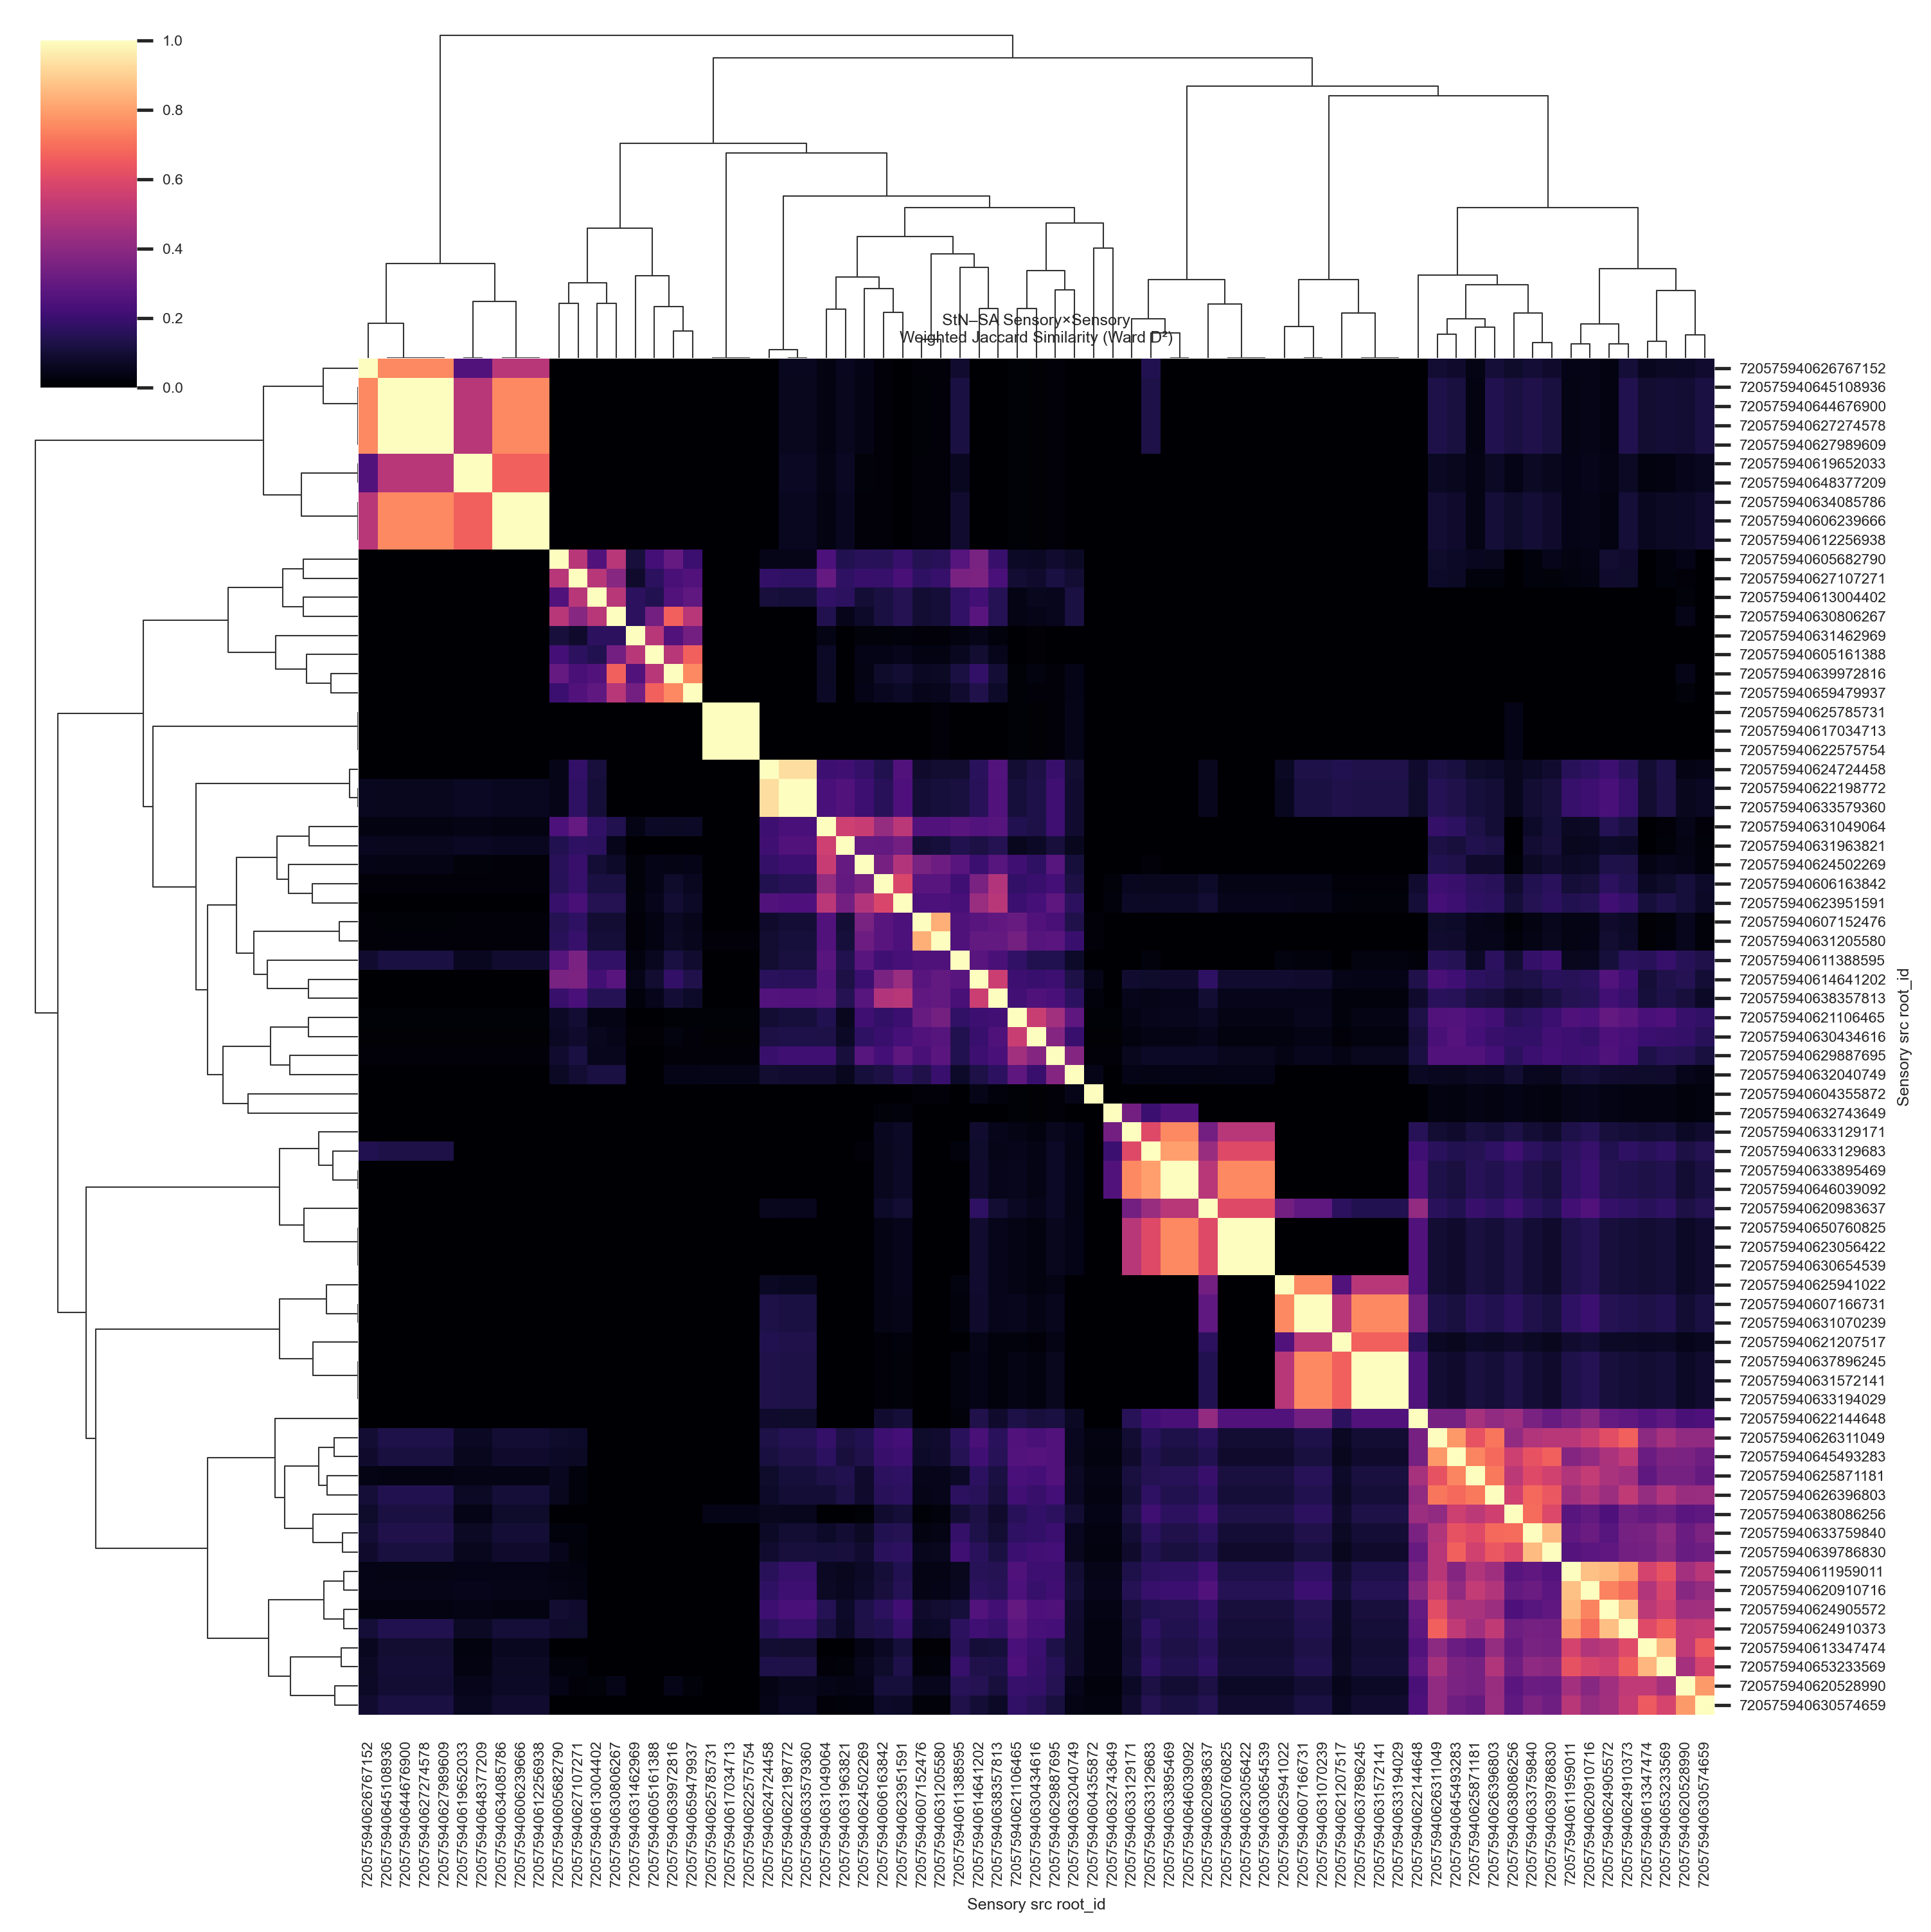

In [20]:
import os
import glob
import pandas as pd
import numpy as np
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage
import seaborn as sns
import matplotlib.pyplot as plt

# ───────────────────────────────────────────────────────────────────────────────
# 1) Load only the StN–SA path CSVs
# ───────────────────────────────────────────────────────────────────────────────
paths_dir = "sensory_to_motor_paths"
pattern   = os.path.join(paths_dir, "StN_SA_Set_*_paths.csv")
files     = glob.glob(pattern)
if not files:
    raise RuntimeError(f"No files matched {pattern}")

df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

# Only keep successful paths
df = df[df["path_found"]]

# ───────────────────────────────────────────────────────────────────────────────
# 2) Build count matrix: rows=sensory src, cols=motor, values=# of distinct paths
# ───────────────────────────────────────────────────────────────────────────────
mat_counts = (
    df
    .pivot_table(
        index="src",
        columns="motor",
        values="path_found",
        aggfunc="size",
        fill_value=0
    )
)

# ───────────────────────────────────────────────────────────────────────────────
# 3) Compute weighted Jaccard similarity
#    wj[i,j] = Σ_k min(a_ik,a_jk) / Σ_k max(a_ik,a_jk)
# ───────────────────────────────────────────────────────────────────────────────
rows    = mat_counts.values
min_mat = np.minimum(rows[:, None, :], rows[None, :, :]).sum(axis=2)
max_mat = np.maximum(rows[:, None, :], rows[None, :, :]).sum(axis=2)
sim_wj  = min_mat / max_mat
sim_wj[np.isnan(sim_wj)] = 1.0   # if both rows all-zero

sim_df = pd.DataFrame(
    sim_wj,
    index=mat_counts.index.astype(str),
    columns=mat_counts.index.astype(str)
)

# ───────────────────────────────────────────────────────────────────────────────
# 4) Compute Ward’s D² linkage on distances (1−similarity)
# ───────────────────────────────────────────────────────────────────────────────
dist_wj = 1.0 - sim_wj
# turn square matrix into condensed form for linkage
condensed = squareform(dist_wj, checks=False)
Z = linkage(condensed, method="ward")


# ───────────────────────────────────────────────────────────────────────────────
# 5) Plot the clustermap
# ───────────────────────────────────────────────────────────────────────────────
sns.set(font_scale=0.5)    # adjust to taste
cg = sns.clustermap(
    sim_df,
    row_linkage=Z,
    col_linkage=Z,
    cmap="magma",
    figsize=(10, 10),
    xticklabels=True,
    yticklabels=True
)

cg.ax_heatmap.set_xlabel("Sensory src root_id")
cg.ax_heatmap.set_ylabel("Sensory src root_id")
cg.ax_heatmap.set_title("StN–SA Sensory×Sensory\nWeighted Jaccard Similarity (Ward D²)")
plt.show()


In [21]:
import os
import glob
import pandas as pd
import numpy as np
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage
import seaborn as sns
import matplotlib.pyplot as plt

# ───────────────────────────────────────────────────────────────────────────────
paths_dir = "sensory_to_motor_paths"
pattern   = os.path.join(paths_dir, "StN_SA_Set_*_paths.csv")
files     = sorted(glob.glob(pattern))
if not files:
    raise RuntimeError(f"No files matched {pattern}")

for fpath in files:
    # Extract set name for titles and filenames
    basename = os.path.basename(fpath)
    set_name = os.path.splitext(basename)[0]  # e.g. "StN_SA_Set_1_paths"

    # 1) Load and filter
    df = pd.read_csv(fpath)
    df = df[df["path_found"]]

    # 2) Build counts matrix
    mat = (
        df
        .pivot_table(
            index="src",
            columns="motor",
            values="path_found",
            aggfunc="size",
            fill_value=0
        )
    )

    # 3) Weighted Jaccard
    rows    = mat.values
    min_mat = np.minimum(rows[:, None, :], rows[None, :, :]).sum(axis=2)
    max_mat = np.maximum(rows[:, None, :], rows[None, :, :]).sum(axis=2)
    sim_wj  = min_mat / max_mat
    sim_wj[np.isnan(sim_wj)] = 1.0

    sim_df = pd.DataFrame(
        sim_wj,
        index=mat.index.astype(str),
        columns=mat.index.astype(str)
    )

    # 4) Ward D² linkage
    dist_wj    = 1.0 - sim_wj
    condensed  = squareform(dist_wj, checks=False)
    Z          = linkage(condensed, method="ward")

    # 5) Plot & save
    sns.set(font_scale=0.6)
    cg = sns.clustermap(
        sim_df,
        row_linkage=Z,
        col_linkage=Z,
        cmap="turbo",
        figsize=(6, 6),
        xticklabels=True,
        yticklabels=True
    )
    cg.ax_heatmap.set_title(f"{set_name}  —  Weighted Jaccard (Ward D²)", pad=75)
    cg.ax_heatmap.set_xlabel("Sensory src root_id")
    cg.ax_heatmap.set_ylabel("Sensory src root_id")

    out_pdf = os.path.join(paths_dir, set_name + "_clustermap.pdf")
    plt.savefig(out_pdf, dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Wrote {out_pdf}")


Wrote sensory_to_motor_paths/StN_SA_Set_1_paths_clustermap.pdf
Wrote sensory_to_motor_paths/StN_SA_Set_2_paths_clustermap.pdf
Wrote sensory_to_motor_paths/StN_SA_Set_3_paths_clustermap.pdf
Wrote sensory_to_motor_paths/StN_SA_Set_4_paths_clustermap.pdf
Wrote sensory_to_motor_paths/StN_SA_Set_5_paths_clustermap.pdf
Wrote sensory_to_motor_paths/StN_SA_Set_6_paths_clustermap.pdf


In [22]:
  # analysis_pipeline.py
# Jupyter‐friendly with your preset paths and corrected GRN file locations

import re
from pathlib import Path
from collections import defaultdict, deque

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import PCA
import umap
from scipy.stats import hypergeom

# ───────────────────────────────────────────────────────────────────────────────
# 0. PRESET PATHS
# ───────────────────────────────────────────────────────────────────────────────
DATA_DIR   = Path.home() / "Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model"
BASE_PATH  = Path("/Users/yaolab/Downloads/taste-connectome-main")
PATHS_DIR  = Path.cwd() / "sensory_to_motor_paths"

# ensure output folder exists
PATHS_DIR.mkdir(exist_ok=True, parents=True)

# ───────────────────────────────────────────────────────────────────────────────
# Utility: sanitize names
# ───────────────────────────────────────────────────────────────────────────────
def sanitize(name: str) -> str:
    return re.sub(r"[^0-9A-Za-z]+", '_', name).strip('_')

# ───────────────────────────────────────────────────────────────────────────────
# 1. Find all shortest motor paths
# ───────────────────────────────────────────────────────────────────────────────
def find_all_motor_paths(src, adj, super_map):
    parents = defaultdict(list)
    dist    = {src: 0}
    queue   = deque([src])
    found   = None
    motors  = set()
    while queue:
        node = queue.popleft()
        d    = dist[node]
        if found is not None and d >= found:
            continue
        for nei in adj.get(node, []):
            nd = d + 1
            if nei not in dist:
                dist[nei] = nd
                queue.append(nei)
            if dist[nei] == nd:
                parents[nei].append(node)
            if super_map.get(nei) == 'motor':
                motors.add(nei)
                if found is None or nd < found:
                    found = nd
    if not motors:
        return {}
    def build(n):
        if n == src:
            return [[src]]
        res = []
        for p in parents[n]:
            for sub in build(p):
                res.append(sub + [n])
        return res
    return {m: build(m) for m in motors}

# ───────────────────────────────────────────────────────────────────────────────
# 2. Load connectome
# ───────────────────────────────────────────────────────────────────────────────
def load_connectome(min_syn=5):
    conns = pd.read_csv(DATA_DIR / 'connections.csv.gz', usecols=['pre_root_id','post_root_id','syn_count'])
    clsf  = pd.read_csv(DATA_DIR / 'classification.csv.gz', usecols=['root_id','super_class'])
    adj   = defaultdict(set)
    for pre, post, cnt in conns.itertuples(index=False):
        if cnt >= min_syn:
            adj[pre].add(post)
    super_map = clsf.set_index('root_id')['super_class'].to_dict()
    return adj, super_map

# ───────────────────────────────────────────────────────────────────────────────
# 3. Define workflows
# ───────────────────────────────────────────────────────────────────────────────
def load_workflows():
    wfs = []
    # StN-SA_v2
    stn = {f"Set {i}": pd.read_csv(BASE_PATH / 'PhN-SA_v2' / f'set_{i}.csv')['root_id'].astype(int)
           for i in range(1,7)}
    wfs.append(('StN-SA', stn))
    # PSO-SA
    pso_files = ['set_1.csv','set_2.csv','set_3.csv']
    pso = {name: pd.read_csv(BASE_PATH / 'aPhN-SA_v3' / fname)['root_id'].astype(int)
           for name,fname in zip(['DCSO','aPhN1','aPhN2'], pso_files)}
    wfs.append(('PSO-SA', pso))
    # MxLbN GRNs (correct absolute paths)
    grn_map = {
        'Sugar/Water': Path('/Users/yaolab/Downloads/sugar_water_GRNs.csv'),
        'Bitter':      Path('/Users/yaolab/Downloads/bitter_GRNs.csv'),
        'Ir94e':       Path('/Users/yaolab/Downloads/Ir94e_GRNs.csv'),
        'Taste Peg':   Path('/Users/yaolab/Downloads/taste_peg_GRNs.csv')
    }
    grn = {k: pd.read_csv(v)['root_id'].astype(int) for k,v in grn_map.items()}
    wfs.append(('MxLbN', grn))
    return wfs

# ───────────────────────────────────────────────────────────────────────────────
# 4. Generate and save paths
# ───────────────────────────────────────────────────────────────────────────────
def generate_paths():
    adj, super_map = load_connectome()
    workflows      = load_workflows()
    for wf_name, sets in workflows:
        wf_safe = sanitize(wf_name)
        for lbl, ids in sets.items():
            lbl_safe = sanitize(lbl)
            rows = []
            for src in ids.unique():
                mp = find_all_motor_paths(src, adj, super_map)
                if not mp:
                    rows.append({'src':src,'motor':'','path_found':False})
                else:
                    for m, paths in mp.items():
                        for p in paths:
                            entry = {'src':src,'motor':m,'path_found':True}
                            for i,node in enumerate(p): entry[f'hop_{i}'] = node
                            rows.append(entry)
            df = pd.DataFrame(rows).fillna('')
            out_csv = PATHS_DIR / f"{wf_safe}_{lbl_safe}_paths.csv"
            df.to_csv(out_csv, index=False)
    print("Paths written to", PATHS_DIR)

# ───────────────────────────────────────────────────────────────────────────────
# 5. Load paths and build matrix
# ───────────────────────────────────────────────────────────────────────────────
def load_paths():
    dfs=[]
    for fp in PATHS_DIR.glob('*_paths.csv'):
        d = pd.read_csv(fp)
        d['source_set'] = fp.stem
        dfs.append(d)
    return pd.concat(dfs, ignore_index=True)

def build_matrix(df, binary=True):
    mat = df[df.path_found].pivot_table(index='src',columns='motor',aggfunc='size',fill_value=0)
    return (mat>0).astype(int) if binary else mat

# ───────────────────────────────────────────────────────────────────────────────
# 6. Plot similarity
# ───────────────────────────────────────────────────────────────────────────────
def plot_similarity(mat):
    sim_j = 1 - pairwise_distances(mat, metric='jaccard')
    sim_c = 1 - pairwise_distances(mat, metric='cosine')
    for name, sim in [('Jaccard', sim_j), ('Cosine', sim_c)]:
        L = linkage(sim, method='average')
        fig,ax = plt.subplots(figsize=(8,8))
        dn = dendrogram(L, labels=mat.index, ax=ax)
        order = dn['ivl']
        im = ax.imshow(sim[np.ix_(dn['leaves'],dn['leaves'])], vmin=0, vmax=1)
        ax.set_xticks(range(len(order))); ax.set_xticklabels(order, rotation=90)
        ax.set_yticks(range(len(order))); ax.set_yticklabels(order)
        fig.colorbar(im, ax=ax)
        ax.set_title(f"{name} similarity")
        plt.tight_layout(); plt.show()

# ───────────────────────────────────────────────────────────────────────────────
# 7. Embed PCA & UMAP
# ───────────────────────────────────────────────────────────────────────────────
def embed_and_plot(mat):
    pca_coords = PCA(2).fit_transform(mat)
    dfp = pd.DataFrame(pca_coords, index=mat.index, columns=['PC1','PC2'])
    sns.scatterplot(x='PC1',y='PC2',data=dfp).set_title('PCA'); plt.show()
    umap_coords = umap.UMAP(2).fit_transform(mat)
    dfu = pd.DataFrame(umap_coords, index=mat.index, columns=['U1','U2'])
    sns.scatterplot(x='U1',y='U2',data=dfu).set_title('UMAP'); plt.show()

# ───────────────────────────────────────────────────────────────────────────────
# 8. Hypergeom tests
# ───────────────────────────────────────────────────────────────────────────────
def hypergeom_tests(df):
    sets = df.source_set.unique(); M = df.motor.nunique()
    records = []
    for i in range(len(sets)):
        for j in range(i+1, len(sets)):
            m1 = set(df[df.source_set==sets[i]].motor)
            m2 = set(df[df.source_set==sets[j]].motor)
            K, n, k = len(m1), len(m2), len(m1 & m2)
            p = hypergeom.sf(k-1, M, K, n)
            records.append({'set1':sets[i],'set2':sets[j],'overlap':k,'p_value':p})
    display(pd.DataFrame(records))

# ───────────────────────────────────────────────────────────────────────────────
# 9. Notebook workflow
# ───────────────────────────────────────────────────────────────────────────────
# %matplotlib inline
# generate_paths()
# df_paths = load_paths()
# display(df_paths.head())
# mat = build_matrix(df_paths)
# plot_similarity(mat)
# embed_and_plot(mat)
# hypergeom_tests(df_paths)


/var/folders/vc/tg6mvd312zq8kcg7w10xlh3r0000gp/T/ipykernel_28294/4262992185.py:30: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z       = linkage(dist_wj, method="ward")


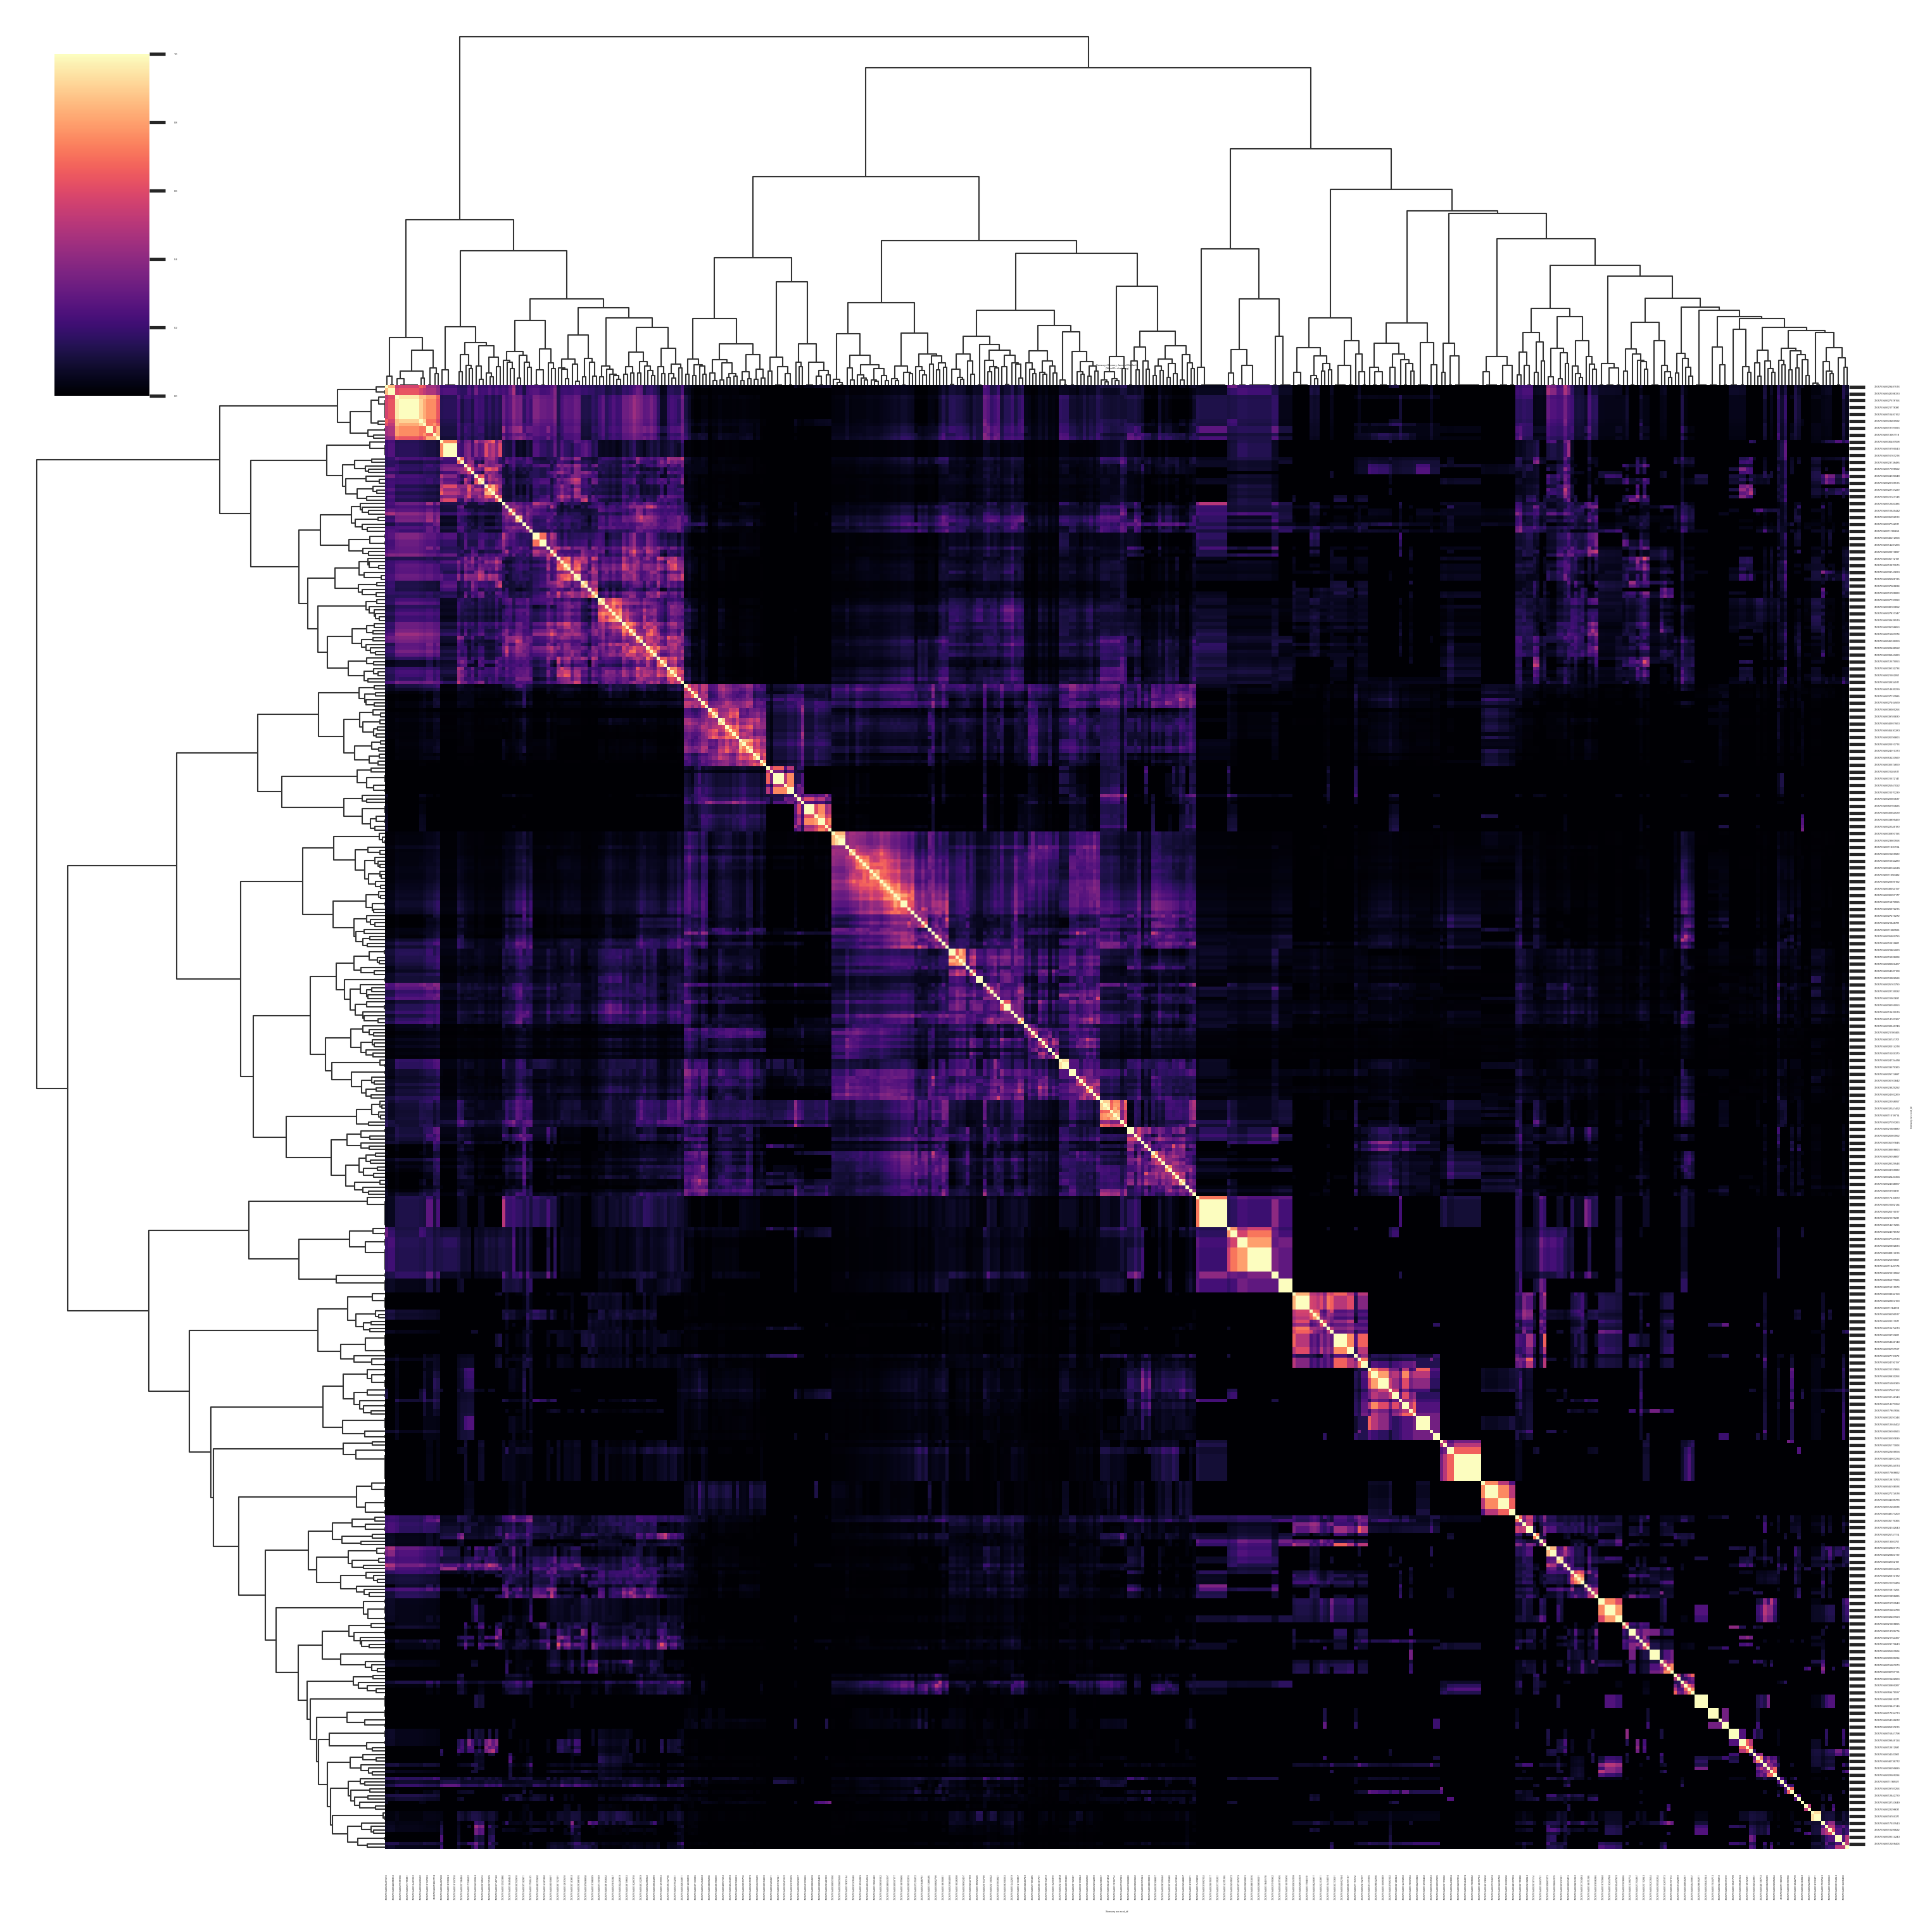

In [23]:
import pandas as pd
import glob, os
import numpy as np
from scipy.cluster.hierarchy import linkage
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Load your path‐CSVs
paths_dir = "sensory_to_motor_paths"
files     = glob.glob(os.path.join(paths_dir, "*_paths.csv"))
df        = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

# 2) Build a counts matrix: rows = sensory src, cols = motor, value = # of paths
mat_counts = (
    df[df["path_found"]]
      .pivot_table(index="src", columns="motor", aggfunc="size", fill_value=0)
)

# 3) Compute weighted Jaccard similarity between rows:
#    wjac[i,j] = sum_k min(a_ik, a_jk) / sum_k max(a_ik, a_jk)
rows = mat_counts.values
min_mat = np.minimum(rows[:, None, :], rows[None, :, :]).sum(axis=2)
max_mat = np.maximum(rows[:, None, :], rows[None, :, :]).sum(axis=2)
sim_wj = min_mat / max_mat
# avoid divide-by-zero rows (if both zero) => set similarity to 1
sim_wj[np.isnan(sim_wj)] = 1.0

# 4) Compute Ward’s D² linkage on the *distance* matrix (1 − similarity)
dist_wj = 1 - sim_wj
Z       = linkage(dist_wj, method="ward")

# 5) Convert to DataFrame for plotting
sens_ids = mat_counts.index.astype(str)
sim_df   = pd.DataFrame(sim_wj, index=sens_ids, columns=sens_ids)

# 5) Plot a cluster‐map of sensory×sensory similarity
sns.set(font_scale=0.07)
cg = sns.clustermap(
    sim_df,
    row_linkage=Z,
    col_linkage=Z,
    cmap="magma",

    figsize=(10, 10)
)

cg.ax_heatmap.set_xlabel("Sensory src root_id")
cg.ax_heatmap.set_ylabel("Sensory src root_id")
cg.ax_heatmap.set_title("Sensory×Sensory Jaccard Similarity\n(Ward D² clustering)")

plt.show()


In [24]:
#!/usr/bin/env python3
import os
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage
import seaborn as sns
import matplotlib.pyplot as plt

# ───────────────────────────────────────────────────────────────────────────────
# 0) CONFIGURATION
# ───────────────────────────────────────────────────────────────────────────────
# Adjust these paths as needed:
DATA_DIR  = Path.home() / "Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model"
SETS_DIR  = Path.home() / "Downloads/taste-connectome-main/PhN-SA_v2"
OUT_DIR   = Path.cwd() / "stn_immediate_downstream"
MIN_SYN   = 5

OUT_DIR.mkdir(exist_ok=True)

# ───────────────────────────────────────────────────────────────────────────────
# 1) LOAD & FILTER CONNECTIONS
# ───────────────────────────────────────────────────────────────────────────────
conns = pd.read_csv(
    DATA_DIR / "connections.csv.gz",
    usecols=["pre_root_id", "post_root_id", "syn_count"]
)
# only keep edges with at least MIN_SYN synapses
conns = conns[conns.syn_count >= MIN_SYN]

# ───────────────────────────────────────────────────────────────────────────────
# 2) COLLATE ALL StN SENSORY ROOT IDs
# ───────────────────────────────────────────────────────────────────────────────
sensory_ids = []
for i in range(1, 7):
    file = SETS_DIR / f"set_{i}.csv"
    ids  = pd.read_csv(file)["root_id"].astype(int).unique().tolist()
    sensory_ids.extend(ids)
sensory_ids = sorted(set(sensory_ids))

# ───────────────────────────────────────────────────────────────────────────────
# 3) BUILD SENSORY×DOWNSTREAM COUNT MATRIX
# ───────────────────────────────────────────────────────────────────────────────
# Filter to only edges out of your StN sensory neurons
df_edges = conns[conns.pre_root_id.isin(sensory_ids)]

# Pivot: rows = sensory src, cols = downstream target, values = syn_count sum
mat_counts = (
    df_edges
    .pivot_table(
        index="pre_root_id",
        columns="post_root_id",
        values="syn_count",
        aggfunc="sum",
        fill_value=0
    )
)
# Rename row/col indices to strings for plotting
sens_ids_str = mat_counts.index.astype(str)

# ───────────────────────────────────────────────────────────────────────────────
# 4) COMPUTE WEIGHTED JACCARD SIMILARITY
#    wj[i,j] = Σ_k min(a_ik, a_jk) / Σ_k max(a_ik, a_jk)
# ───────────────────────────────────────────────────────────────────────────────
rows    = mat_counts.values
min_mat = np.minimum(rows[:, None, :], rows[None, :, :]).sum(axis=2)
max_mat = np.maximum(rows[:, None, :], rows[None, :, :]).sum(axis=2)
sim_wj  = min_mat / max_mat
sim_wj[np.isnan(sim_wj)] = 1.0

sim_df = pd.DataFrame(sim_wj, index=sens_ids_str, columns=sens_ids_str)

# ───────────────────────────────────────────────────────────────────────────────
# 5) WARD D² CLUSTERING ON DISTANCES (1 − similarity)
# ───────────────────────────────────────────────────────────────────────────────
dist_wj   = 1.0 - sim_wj
condensed = squareform(dist_wj, checks=False)
Z         = linkage(condensed, method="ward")  # SciPy’s Ward.D²

# ───────────────────────────────────────────────────────────────────────────────
# 6) PLOT & SAVE CLUSTERMAP
# ───────────────────────────────────────────────────────────────────────────────
sns.set(font_scale=0.6)
cg = sns.clustermap(
    sim_df,
    row_linkage=Z,
    col_linkage=Z,
    cmap="turbo",
    figsize=(12, 12),
    xticklabels=True,
    yticklabels=True
)
cg.ax_heatmap.set_title(
    "StN-SA Sensory×Immediate Downstream\nWeighted Jaccard (Ward D²)",
    pad=80
)
cg.ax_heatmap.set_xlabel("Sensory src root_id")
cg.ax_heatmap.set_ylabel("Sensory src root_id")

out_pdf = OUT_DIR / "StN_all_downstream_clustermap.pdf"
plt.savefig(out_pdf, dpi=150, bbox_inches="tight")
plt.close()
print(f"Wrote visualization → {out_pdf}")


Wrote visualization → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/stn_immediate_downstream/StN_all_downstream_clustermap.pdf


In [25]:
#!/usr/bin/env python3
import os
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage
import seaborn as sns
import matplotlib.pyplot as plt

# ───────────────────────────────────────────────────────────────────────────────
# 0) CONFIGURATION
# ───────────────────────────────────────────────────────────────────────────────
DATA_DIR  = Path.home() / "Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model"
SETS_DIR  = Path.home() / "Downloads/taste-connectome-main/PhN-SA_v2"
OUT_DIR   = Path.cwd() / "stn_cosine_downstream"
MIN_SYN   = 5

OUT_DIR.mkdir(exist_ok=True)

# ───────────────────────────────────────────────────────────────────────────────
# 1) LOAD & FILTER CONNECTIONS
# ───────────────────────────────────────────────────────────────────────────────
conns = pd.read_csv(
    DATA_DIR / "connections.csv.gz",
    usecols=["pre_root_id", "post_root_id", "syn_count"]
)
conns = conns[conns.syn_count >= MIN_SYN]

# ───────────────────────────────────────────────────────────────────────────────
# 2) COLLATE ALL StN SENSORY ROOT IDs
# ───────────────────────────────────────────────────────────────────────────────
sensory_ids = []
for i in range(1, 7):
    ids = pd.read_csv(SETS_DIR / f"set_{i}.csv")["root_id"].astype(int).unique().tolist()
    sensory_ids.extend(ids)
sensory_ids = sorted(set(sensory_ids))

# ───────────────────────────────────────────────────────────────────────────────
# 3) BUILD SENSORY×DOWNSTREAM COUNT MATRIX
# ───────────────────────────────────────────────────────────────────────────────
df_edges = conns[conns.pre_root_id.isin(sensory_ids)]

mat_counts = (
    df_edges
    .pivot_table(
        index="pre_root_id",
        columns="post_root_id",
        values="syn_count",
        aggfunc="sum",
        fill_value=0
    )
)
sens_ids_str = mat_counts.index.astype(str)

# ───────────────────────────────────────────────────────────────────────────────
# 4) COMPUTE COSINE SIMILARITY
#    sim[i,j] = (a_i ⋅ a_j) / (‖a_i‖ · ‖a_j‖)
# ───────────────────────────────────────────────────────────────────────────────
rows = mat_counts.values
# dot products between all pairs
dotp = rows @ rows.T
# norms of each row
norms = np.linalg.norm(rows, axis=1)
# outer product of norms
norm_matrix = np.outer(norms, norms)
# avoid division by zero
with np.errstate(divide='ignore', invalid='ignore'):
    sim_cos = dotp / norm_matrix
# Where either vector was zero, set similarity to 0 (except diagonal)
sim_cos[ norm_matrix == 0 ] = 0.0
# enforce exact 1.0 on diagonal
np.fill_diagonal(sim_cos, 1.0)

sim_df = pd.DataFrame(sim_cos, index=sens_ids_str, columns=sens_ids_str)

# ───────────────────────────────────────────────────────────────────────────────
# 5) WARD D² CLUSTERING ON DISTANCES (1 − similarity)
# ───────────────────────────────────────────────────────────────────────────────
dist_cos   = 1.0 - sim_cos
condensed  = squareform(dist_cos, checks=False)
Z          = linkage(condensed, method="ward")  # SciPy’s Ward.D²

# ───────────────────────────────────────────────────────────────────────────────
# 6) PLOT & SAVE CLUSTERMAP
# ───────────────────────────────────────────────────────────────────────────────
sns.set(font_scale=0.6)
cg = sns.clustermap(
    sim_df,
    row_linkage=Z,
    col_linkage=Z,
    cmap="turbo",
    figsize=(12, 12),
    xticklabels=True,
    yticklabels=True
)
cg.ax_heatmap.set_title(
    "StN-SA Sensory×Immediate Downstream\nCosine Similarity (Ward D²)",
    pad=80
)
cg.ax_heatmap.set_xlabel("Sensory src root_id")
cg.ax_heatmap.set_ylabel("Sensory src root_id")

out_pdf = OUT_DIR / "StN_all_downstream_cosine_clustermap.pdf"
plt.savefig(out_pdf, dpi=150, bbox_inches="tight")
plt.close()
print(f"Wrote visualization → {out_pdf}")


Wrote visualization → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/stn_cosine_downstream/StN_all_downstream_cosine_clustermap.pdf


In [26]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage
import seaborn as sns
import matplotlib.pyplot as plt

# ───────────────────────────────────────────────────────────────────────────────
# 0) CONFIGURATION
# ───────────────────────────────────────────────────────────────────────────────
DATA_DIR = Path.home() / "Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model"
SETS_DIR = Path.home() / "Downloads/taste-connectome-main/PhN-SA_v2"
OUT_DIR  = Path.cwd() / "stn_cosine_downstream"
MIN_SYN  = 5

# make sure the output folder exists
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ───────────────────────────────────────────────────────────────────────────────
# 1) LOAD & FILTER CONNECTIONS
# ───────────────────────────────────────────────────────────────────────────────
conns = pd.read_csv(
    DATA_DIR / "connections.csv.gz",
    usecols=["pre_root_id", "post_root_id", "syn_count"]
)
# only keep edges with ≥ MIN_SYN synapses
conns = conns[conns.syn_count >= MIN_SYN]
# ensure integer IDs
conns["pre_root_id"] = conns["pre_root_id"].astype(int)
conns["post_root_id"] = conns["post_root_id"].astype(int)

# ───────────────────────────────────────────────────────────────────────────────
# 2) COLLATE ALL StN SENSORY ROOT IDs
# ───────────────────────────────────────────────────────────────────────────────
sensory_ids = set()
for i in range(1, 7):
    df_set = pd.read_csv(SETS_DIR / f"set_{i}.csv")
    sensory_ids.update(df_set["root_id"].astype(int).tolist())
sensory_ids = sorted(sensory_ids)

# ───────────────────────────────────────────────────────────────────────────────
# 3) BUILD SENSORY×DOWNSTREAM COUNT MATRIX
# ───────────────────────────────────────────────────────────────────────────────
# filter to only your StN sensory neurons
df_edges = conns[conns.pre_root_id.isin(sensory_ids)]

mat_counts = df_edges.pivot_table(
    index="pre_root_id",
    columns="post_root_id",
    values="syn_count",
    aggfunc="sum",
    fill_value=0
)
# for labeling
sens_ids_str = mat_counts.index.astype(str)

# ───────────────────────────────────────────────────────────────────────────────
# 4) COMPUTE COSINE SIMILARITY
#    sim[i,j] = (a_i · a_j) / (‖a_i‖ · ‖a_j‖)
# ───────────────────────────────────────────────────────────────────────────────
rows = mat_counts.values
dotp = rows.dot(rows.T)
norms = np.linalg.norm(rows, axis=1)
norm_matrix = np.outer(norms, norms)

with np.errstate(divide="ignore", invalid="ignore"):
    sim_cos = dotp / norm_matrix

# zero‐vector rows → zero similarity (off‐diag), diag=1
sim_cos[norm_matrix == 0] = 0.0
np.fill_diagonal(sim_cos, 1.0)

sim_df = pd.DataFrame(sim_cos, index=sens_ids_str, columns=sens_ids_str)

# ───────────────────────────────────────────────────────────────────────────────
# 5) WARD D² CLUSTERING ON DISTANCES (1 − similarity)
# ───────────────────────────────────────────────────────────────────────────────
dist_cos = 1.0 - sim_cos
condensed = squareform(dist_cos, checks=False)
Z = linkage(condensed, method="ward")  # SciPy’s Ward.D²

# ───────────────────────────────────────────────────────────────────────────────
# 6) PLOT & SAVE CLUSTERMAP
# ───────────────────────────────────────────────────────────────────────────────
sns.set(font_scale=0.6)
cg = sns.clustermap(
    sim_df,
    row_linkage=Z,
    col_linkage=Z,
    cmap="turbo",
    figsize=(12, 12),
    xticklabels=True,
    yticklabels=True
)
cg.ax_heatmap.set_title(
    "StN-SA Sensory×Immediate Downstream\nCosine Similarity (Ward D²)",
    pad=80
)
cg.ax_heatmap.set_xlabel("Sensory src root_id")
cg.ax_heatmap.set_ylabel("Sensory src root_id")

out_pdf = OUT_DIR / "StN_all_downstream_cosine_clustermap.pdf"
plt.savefig(out_pdf, dpi=150, bbox_inches="tight")
plt.close()
print(f"Wrote visualization → {out_pdf}")


Wrote visualization → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/stn_cosine_downstream/StN_all_downstream_cosine_clustermap.pdf


In [27]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
from pathlib import Path
from collections import defaultdict
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage
import seaborn as sns
import matplotlib.pyplot as plt

# ───────────────────────────────────────────────────────────────────────────────
# 0) CONFIGURATION
# ───────────────────────────────────────────────────────────────────────────────
DATA_DIR = Path.home() / "Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model"
SETS_DIR = Path.home() / "Downloads/taste-connectome-main/PhN-SA_v2"
OUT_DIR  = Path.cwd() / "stn_2hop_cosine"
MIN_SYN  = 5

OUT_DIR.mkdir(parents=True, exist_ok=True)

# ───────────────────────────────────────────────────────────────────────────────
# 1) LOAD & FILTER CONNECTIONS
# ───────────────────────────────────────────────────────────────────────────────
conns = pd.read_csv(
    DATA_DIR / "connections.csv.gz",
    usecols=["pre_root_id","post_root_id","syn_count"]
)
conns = conns[conns.syn_count >= MIN_SYN]
conns["pre_root_id"]  = conns["pre_root_id"].astype(int)
conns["post_root_id"] = conns["post_root_id"].astype(int)

# build adjacency‐weight dict: adj_weights[src][tgt] = syn_count
adj_weights = defaultdict(dict)
for pre, post, cnt in conns.itertuples(index=False):
    adj_weights[pre][post] = cnt

# ───────────────────────────────────────────────────────────────────────────────
# 2) COLLECT StN SENSORY ROOT IDs
# ───────────────────────────────────────────────────────────────────────────────
sensory_ids = set()
for i in range(1,7):
    df_set = pd.read_csv(SETS_DIR / f"set_{i}.csv")
    sensory_ids.update(df_set["root_id"].astype(int).tolist())
sensory_ids = sorted(sensory_ids)

# ───────────────────────────────────────────────────────────────────────────────
# 3) BUILD 1-HOP & 2-HOP COUNTS
# ───────────────────────────────────────────────────────────────────────────────
one_hop = {}  # one_hop[src][tgt] = direct syn_count
two_hop = {}  # two_hop[src][tgt] = sum of min(cnt1,cnt2) over all src->mid->tgt paths

for src in sensory_ids:
    # 1-hop
    direct = adj_weights.get(src, {})
    one_hop[src] = direct.copy()
    # 2-hop
    accum = defaultdict(int)
    for mid, cnt1 in direct.items():
        for tgt, cnt2 in adj_weights.get(mid, {}).items():
            w = min(cnt1, cnt2)
            accum[tgt] += w
    two_hop[src] = dict(accum)

# combine into a single matrix: combined[src][tgt] = one_hop + two_hop
combined = {}
for src in sensory_ids:
    combo = defaultdict(int)
    for tgt, cnt in one_hop[src].items():
        combo[tgt] += cnt
    for tgt, cnt in two_hop[src].items():
        combo[tgt] += cnt
    combined[src] = dict(combo)

#  ─────────────────────────────────────────────────────────────────────────────
# 4) TURN combined INTO A DataFrame
# ───────────────────────────────────────────────────────────────────────────────
all_tgts = sorted({t for d in combined.values() for t in d.keys()})
mat = pd.DataFrame(
    0,
    index=sensory_ids,
    columns=all_tgts,
    dtype=float
)
for src, feats in combined.items():
    for tgt, val in feats.items():
        mat.at[src, tgt] = val

# label strings for plotting
sens_str = mat.index.astype(str)
mat.index = sens_str
mat.columns = mat.columns.astype(str)

# ───────────────────────────────────────────────────────────────────────────────
# 5) COMPUTE COSINE SIMILARITY
# ───────────────────────────────────────────────────────────────────────────────
X = mat.values
dotp = X.dot(X.T)
norms = np.linalg.norm(X, axis=1)
normmat = np.outer(norms, norms)

with np.errstate(divide='ignore', invalid='ignore'):
    sim = dotp / normmat

# zero vectors → off‐diag=0, diag=1
sim[normmat == 0] = 0.0
np.fill_diagonal(sim, 1.0)

sim_df = pd.DataFrame(sim, index=sens_str, columns=sens_str)

# ───────────────────────────────────────────────────────────────────────────────
# 6) WARD D² CLUSTERING & PLOTTING
# ───────────────────────────────────────────────────────────────────────────────
dist = 1.0 - sim
cond = squareform(dist, checks=False)
Z    = linkage(cond, method="ward")  # SciPy’s Ward.D²

sns.set(font_scale=0.6)
cg = sns.clustermap(
    sim_df,
    row_linkage=Z,
    col_linkage=Z,
    cmap="turbo",
    figsize=(12,12),
    xticklabels=True,
    yticklabels=True
)
cg.ax_heatmap.set_title(
    "StN-SA Sensory→(1+2)-Hop Downstream\nCosine Similarity (Ward D²)",
    pad=80
)
cg.ax_heatmap.set_xlabel("Sensory root_id")
cg.ax_heatmap.set_ylabel("Sensory root_id")

out_pdf = OUT_DIR / "StN_1to2hop_cosine_clustermap.pdf"
plt.savefig(out_pdf, dpi=150, bbox_inches="tight")
plt.close()
print(f"Wrote → {out_pdf}")


Wrote → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/stn_2hop_cosine/StN_1to2hop_cosine_clustermap.pdf


In [29]:
#!/usr/bin/env python3
"""
analysis_pipeline_one_hop.py

Generate one‐hop downstream connection CSVs for each workflow and set.
Each row is one direct downstream connection (or a “no‐hop” record if none).
"""

import re
from pathlib import Path
from collections import defaultdict

import pandas as pd

# ─── 0. PRESET PATHS ──────────────────────────────────────────────────────────
DATA_DIR  = Path.home() / "Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model"
BASE_PATH = Path("/Users/yaolab/Downloads/taste-connectome-main")
OUT_DIR   = Path.cwd() / "sensory_to_all_downstream"
OUT_DIR.mkdir(exist_ok=True, parents=True)

def sanitize(name: str) -> str:
    """Turn arbitrary string into a filesystem‐safe label."""
    return re.sub(r"[^0-9A-Za-z]+", "_", name).strip("_")

# ─── 1. LOAD THE CONNECTOME ────────────────────────────────────────────────────
def load_connectome(min_syn: int = 5):
    """
    Reads connections.csv.gz, filters for syn_count >= min_syn,
    and returns an adjacency list mapping each pre_root_id to a list
    of (post_root_id, syn_count).
    """
    conns = pd.read_csv(
        DATA_DIR / "connections.csv.gz",
        usecols=["pre_root_id","post_root_id","syn_count"]
    )
    conns = conns[conns.syn_count >= min_syn]
    adj = defaultdict(list)
    for pre, post, cnt in conns.itertuples(index=False):
        adj[int(pre)].append((int(post), int(cnt)))
    return adj

# ─── 2. DEFINE YOUR WORKFLOWS ─────────────────────────────────────────────────
def load_workflows():
    """
    Returns a list of (workflow_name, {set_label: pd.Series of root_ids})
    matching the original pipeline’s structure.
    """
    wfs = []
    # 2a) StN-SA v2 (Sets 1–6)
    stn = {
        f"Set {i}": pd.read_csv(BASE_PATH / "PhN-SA_v2" / f"set_{i}.csv")["root_id"].astype(int)
        for i in range(1, 7)
    }
    wfs.append(("StN-SA", stn))

    # 2b) PSO-SA (DCSO, aPhN1, aPhN2)
    pso_files = ["set_1.csv", "set_2.csv", "set_3.csv"]
    pso_names = ["DCSO", "aPhN1", "aPhN2"]
    pso = {
        name: pd.read_csv(BASE_PATH / "aPhN-SA_v3" / fname)["root_id"].astype(int)
        for name, fname in zip(pso_names, pso_files)
    }
    wfs.append(("PSO-SA", pso))

    # 2c) MxLbN GRNs (Sugar/Water, Bitter, Ir94e, Taste Peg)
    grn_dir = Path.home() / "Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/connectome_analysis/Input_Files/MxLbN-SA_sets"
    grn_map = {
        "Sugar/Water": grn_dir / "sugar_water_GRNs.csv",
        "Bitter":      grn_dir / "bitter_GRNs.csv",
        "Ir94e":       grn_dir / "Ir94e_GRNs.csv",
        "Taste Peg":   grn_dir / "taste_peg_GRNs.csv",
    }
    grn = {
        k: pd.read_csv(v)["root_id"].astype(int)
        for k, v in grn_map.items()
    }
    wfs.append(("MxLbN", grn))

    return wfs

# ─── 3. FIND ONE-HOP DOWNSTREAM ───────────────────────────────────────────────
def find_one_hop(src: int, adj: dict) -> list[tuple[int,int]]:
    """
    Return list of (downstream_root_id, syn_count) for direct targets of src.
    """
    return adj.get(src, [])

# ─── 4. GENERATE & SAVE CSVs ──────────────────────────────────────────────────
def generate_one_hop(min_syn: int = 5):
    adj       = load_connectome(min_syn=min_syn)
    workflows = load_workflows()

    for wf_name, sets in workflows:
        wf_safe = sanitize(wf_name)
        for lbl, ids in sets.items():
            lbl_safe = sanitize(lbl)
            rows = []
            for src in ids.unique():
                targets = find_one_hop(src, adj)
                if not targets:
                    # record that no downstream connections passed the filter
                    rows.append({
                        "src":         src,
                        "downstream":  "",
                        "syn_count":   0,
                        "path_found": False,
                        "hop_0":       src,
                        "hop_1":       ""
                    })
                else:
                    for down, cnt in targets:
                        rows.append({
                            "src":         src,
                            "downstream":  down,
                            "syn_count":   cnt,
                            "path_found":  True,
                            "hop_0":       src,
                            "hop_1":       down
                        })

            df = pd.DataFrame(rows).fillna("")
            out_csv = OUT_DIR / f"{wf_safe}_{lbl_safe}_one_hop.csv"
            df.to_csv(out_csv, index=False)

    print(f"One‐hop downstream CSVs written to: {OUT_DIR.resolve()}")

# ─── 5. ENTRY POINT ──────────────────────────────────────────────────────────
if __name__ == "__main__":
    # you can pass a different min_syn if you wish
    generate_one_hop(min_syn=5)


One‐hop downstream CSVs written to: /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_all_downstream


One‐hop downstream CSVs written to: /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_all_downstream


/var/folders/vc/tg6mvd312zq8kcg7w10xlh3r0000gp/T/ipykernel_28294/55029269.py:156: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/Users/yaolab/.pyenv/versions/scanpyenv-3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


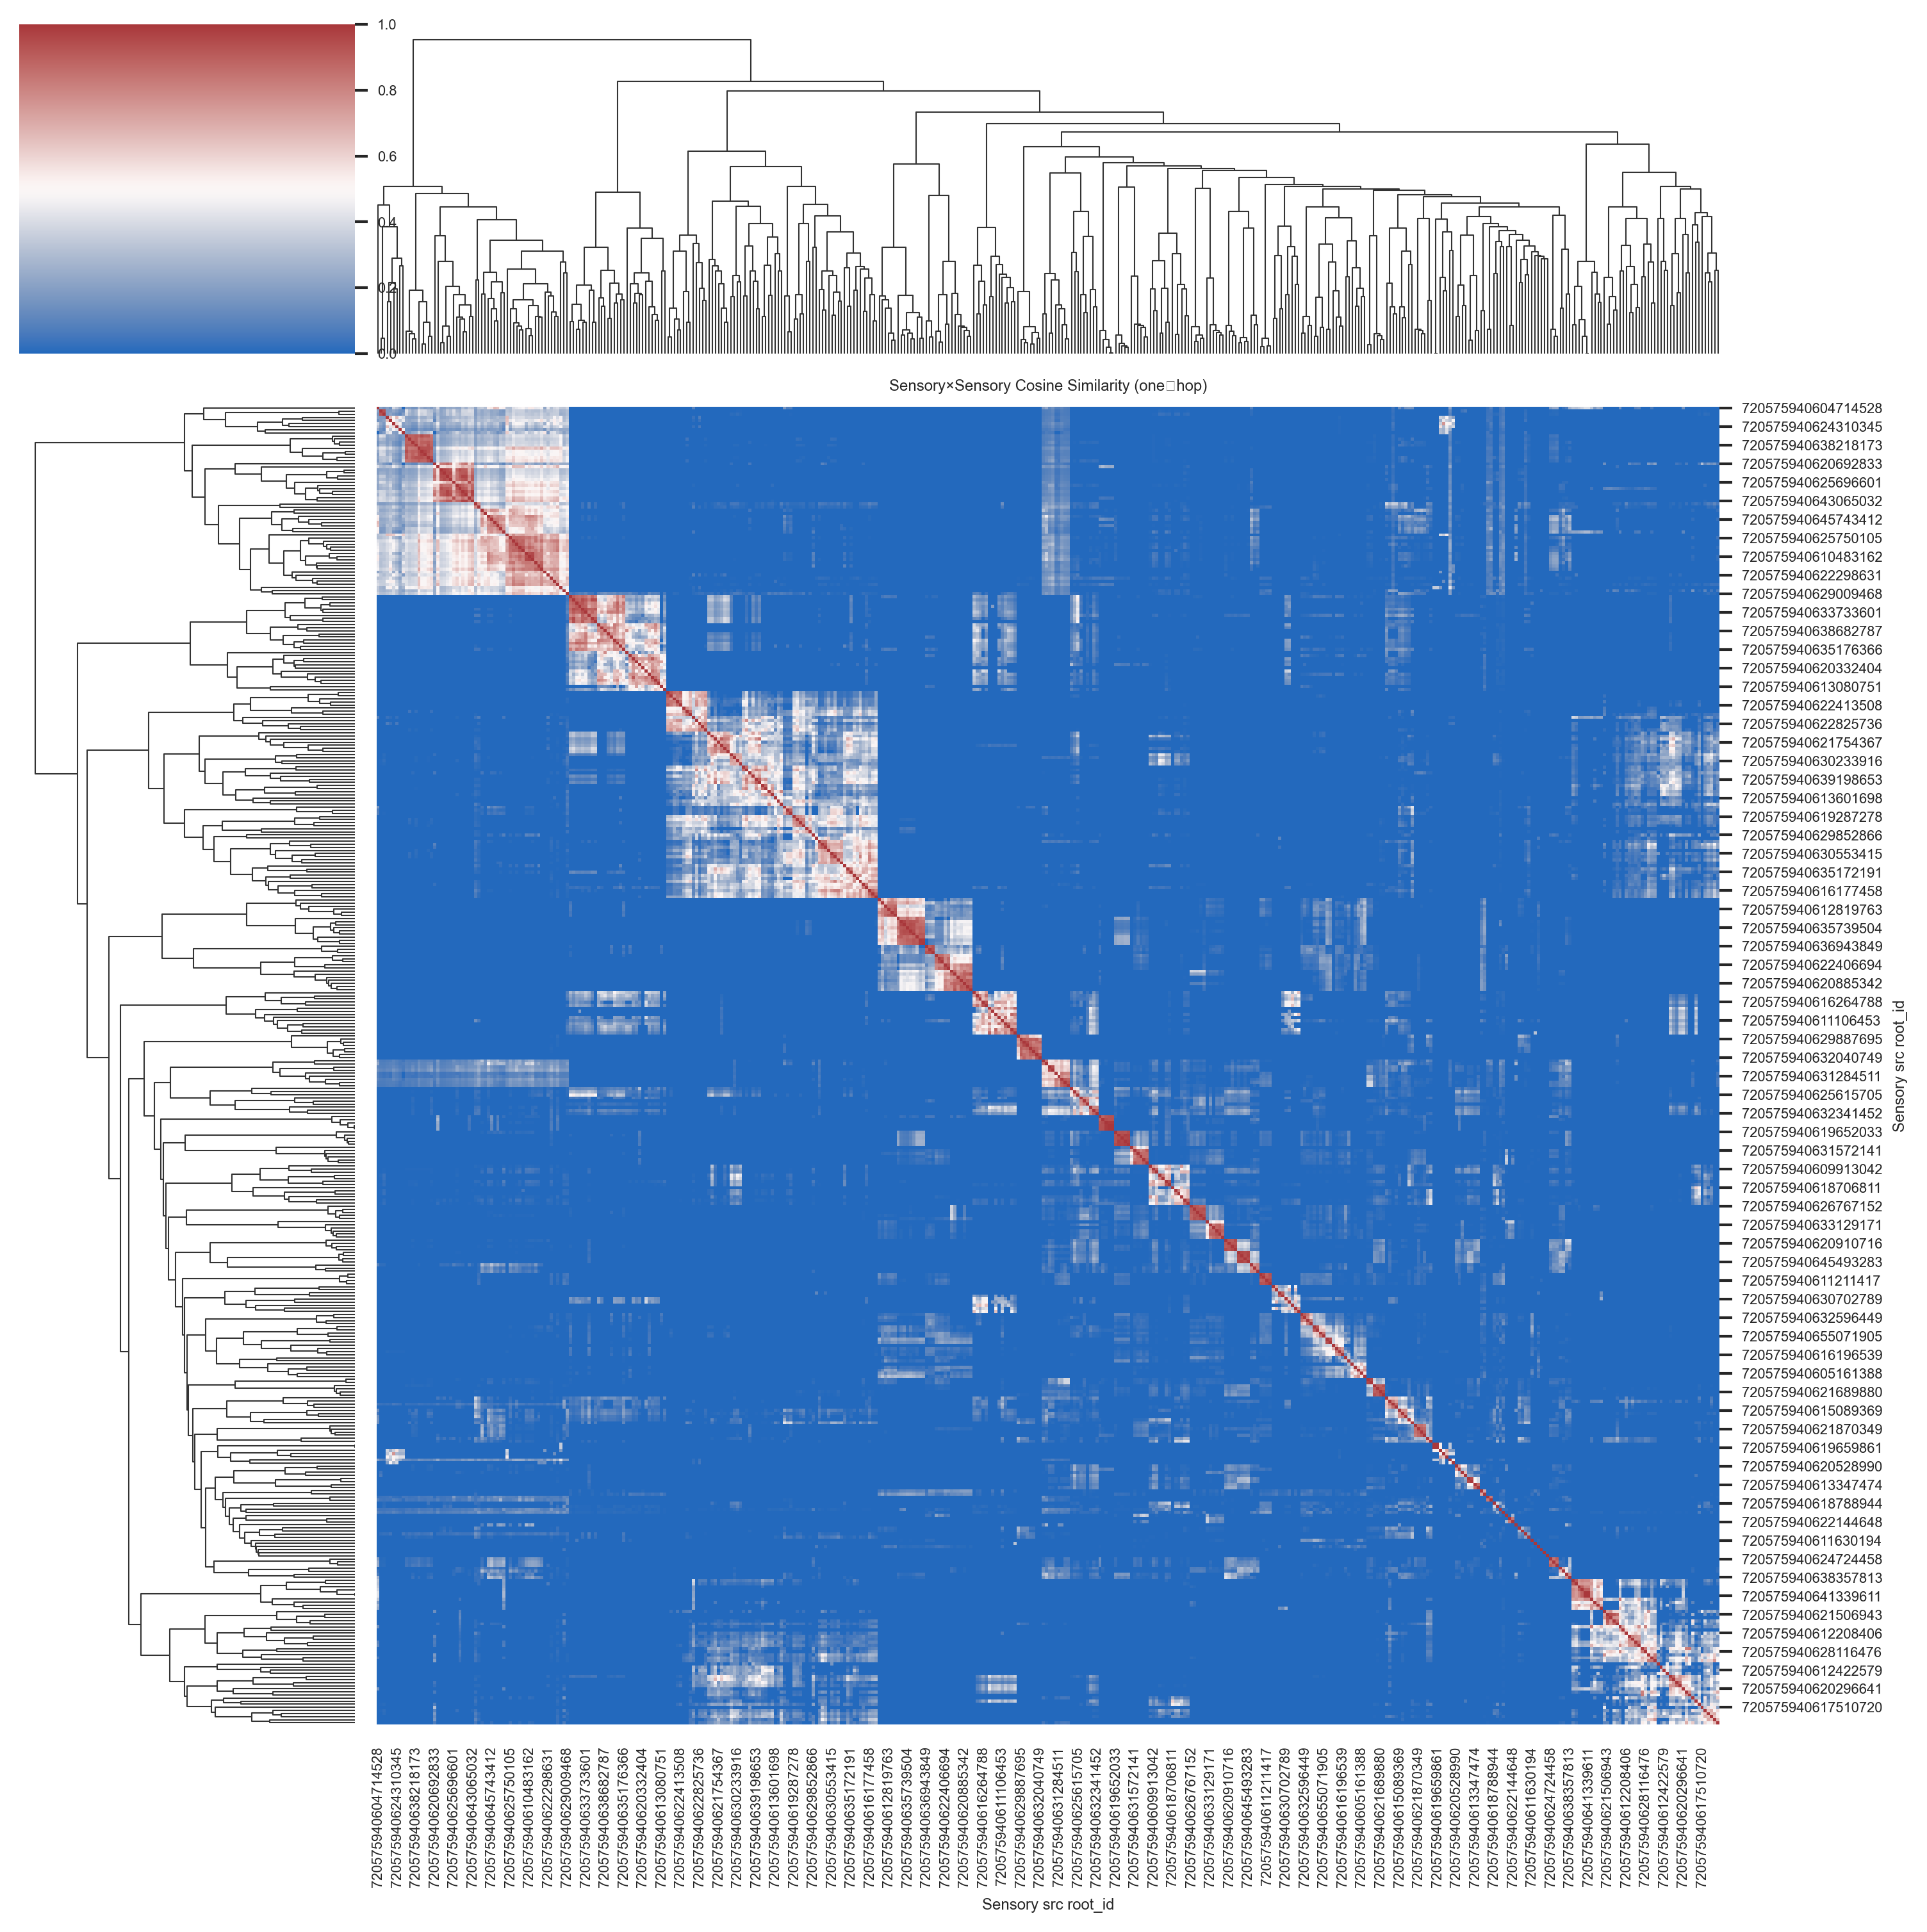

In [30]:
#!/usr/bin/env python3
"""
analysis_pipeline_one_hop.py

1) Generate one‐hop downstream CSVs for each workflow & set.
2) Load all one‐hop CSVs, build a src×downstream matrix (syn_count).
3) Compute cosine similarity between sensory src rows.
4) Display a clustered heat-map of that similarity.
"""

import re
from pathlib import Path
from collections import defaultdict
import glob

import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances
import seaborn as sns
import matplotlib.pyplot as plt

# ─── 0. PRESET PATHS ──────────────────────────────────────────────────────────
DATA_DIR  = Path.home() / "Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model"
BASE_PATH = Path("/Users/yaolab/Downloads/taste-connectome-main")
OUT_DIR   = Path.cwd() / "sensory_to_all_downstream"
OUT_DIR.mkdir(exist_ok=True, parents=True)

def sanitize(name: str) -> str:
    return re.sub(r"[^0-9A-Za-z]+", "_", name).strip("_")

# ─── 1. LOAD THE CONNECTOME ────────────────────────────────────────────────────
def load_connectome(min_syn: int = 5):
    conns = pd.read_csv(
        DATA_DIR / "connections.csv.gz",
        usecols=["pre_root_id","post_root_id","syn_count"]
    )
    conns = conns[conns.syn_count >= min_syn]
    adj = defaultdict(list)
    for pre, post, cnt in conns.itertuples(index=False):
        adj[int(pre)].append((int(post), int(cnt)))
    return adj

# ─── 2. DEFINE WORKFLOWS ──────────────────────────────────────────────────────
def load_workflows():
    wfs = []
    # StN-SA v2 (Sets 1–6)
    stn = {
        f"Set {i}": pd.read_csv(BASE_PATH / "PhN-SA_v2" / f"set_{i}.csv")["root_id"].astype(int)
        for i in range(1, 7)
    }
    wfs.append(("StN-SA", stn))

    # PSO-SA (DCSO, aPhN1, aPhN2)
    pso_files = ["set_1.csv", "set_2.csv", "set_3.csv"]
    pso_names = ["DCSO", "aPhN1", "aPhN2"]
    pso = {
        name: pd.read_csv(BASE_PATH / "aPhN-SA_v3" / fname)["root_id"].astype(int)
        for name, fname in zip(pso_names, pso_files)
    }
    wfs.append(("PSO-SA", pso))

    # MxLbN GRNs
    grn_dir = Path.home() / "Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/connectome_analysis/Input_Files/MxLbN-SA_sets"
    grn_map = {
        "Sugar/Water": grn_dir / "sugar_water_GRNs.csv",
        "Bitter":      grn_dir / "bitter_GRNs.csv",
        "Ir94e":       grn_dir / "Ir94e_GRNs.csv",
        "Taste Peg":   grn_dir / "taste_peg_GRNs.csv",
    }
    grn = {
        k: pd.read_csv(v)["root_id"].astype(int)
        for k, v in grn_map.items()
    }
    wfs.append(("MxLbN", grn))

    return wfs

# ─── 3. FIND ONE‐HOP DOWNSTREAM ───────────────────────────────────────────────
def find_one_hop(src: int, adj: dict) -> list[tuple[int,int]]:
    return adj.get(src, [])

# ─── 4. GENERATE & SAVE CSVs ──────────────────────────────────────────────────
def generate_one_hop(min_syn: int = 5):
    adj       = load_connectome(min_syn=min_syn)
    workflows = load_workflows()

    for wf_name, sets in workflows:
        wf_safe = sanitize(wf_name)
        for lbl, ids in sets.items():
            lbl_safe = sanitize(lbl)
            rows = []
            for src in ids.unique():
                targets = find_one_hop(src, adj)
                if not targets:
                    rows.append({
                        "src":         src,
                        "downstream":  "",
                        "syn_count":   0,
                        "path_found": False,
                        "hop_0":       src,
                        "hop_1":       ""
                    })
                else:
                    for down, cnt in targets:
                        rows.append({
                            "src":         src,
                            "downstream":  down,
                            "syn_count":   cnt,
                            "path_found":  True,
                            "hop_0":       src,
                            "hop_1":       down
                        })

            df = pd.DataFrame(rows).fillna("")
            out_csv = OUT_DIR / f"{wf_safe}_{lbl_safe}_one_hop.csv"
            df.to_csv(out_csv, index=False)

    print(f"One‐hop downstream CSVs written to: {OUT_DIR.resolve()}")

# ─── 5. LOAD ONE‐HOP AND BUILD MATRIX ───────────────────────────────────────────
def load_one_hop_matrix(binary: bool = False):
    # load all *_one_hop.csv files
    files = glob.glob(str(OUT_DIR / "*_one_hop.csv"))
    df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

    # only keep found paths
    df = df[df.path_found]

    # pivot: rows=src, cols=downstream, value=syn_count (or count of rows if binary)
    if binary:
        mat = df.pivot_table(index="src", columns="downstream",
                             aggfunc="size", fill_value=0)
        return (mat > 0).astype(int)
    else:
        mat = df.pivot_table(index="src", columns="downstream",
                             values="syn_count", aggfunc="sum", fill_value=0)
        return mat

# ─── 6. PLOT COSINE SIMILARITY HEATMAP ─────────────────────────────────────────
def plot_cosine_heatmap(mat: pd.DataFrame):
    # cosine similarity = 1 - cosine distance
    dist = pairwise_distances(mat.values, metric="cosine")
    sim  = 1 - dist

    # cluster and plot with seaborn clustermap
    sns.set_context("paper", font_scale=0.6)
    cg = sns.clustermap(
        pd.DataFrame(sim, index=mat.index.astype(str), columns=mat.index.astype(str)),
        row_cluster=True, col_cluster=True,
        cmap="vlag", center=0.5,
        figsize=(10, 10)
    )
    cg.ax_heatmap.set_xlabel("Sensory src root_id")
    cg.ax_heatmap.set_ylabel("Sensory src root_id")
    cg.ax_heatmap.set_title("Sensory×Sensory Cosine Similarity (one‐hop)")
    plt.tight_layout()
    plt.show()

# ─── 7. ENTRY POINT ──────────────────────────────────────────────────────────
if __name__ == "__main__":
    # Step 1–4: generate your one‐hop files
    generate_one_hop(min_syn=5)

    # Step 5: load matrix (use binary=True if you only care presence/absence)
    mat = load_one_hop_matrix(binary=False)

    # Step 6: plot cosine-similarity heat map
    plot_cosine_heatmap(mat)


In [44]:
#!/usr/bin/env python3
"""
analysis_pipeline_one_hop_grouped.py

1) Generate one‐hop downstream CSVs for each workflow & set.
2) Load all one‐hop CSVs, build a (workflow,group,src)×downstream matrix.
3) Compute row‐wise cosine similarity.
4) Display a clustered heat‐map with two color bars:
     • workflow category
     • individual group
"""

import re
from pathlib import Path
import glob
from collections import defaultdict

import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances
import seaborn as sns
import matplotlib.pyplot as plt

# ─── 0. PRESET PATHS ──────────────────────────────────────────────────────────
DATA_DIR  = Path.home() / "Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model"
BASE_PATH = Path("/Users/yaolab/Downloads/taste-connectome-main")
OUT_DIR   = Path.cwd() / "sensory_to_all_downstream"
OUT_DIR.mkdir(exist_ok=True, parents=True)

def sanitize(name: str) -> str:
    return re.sub(r"[^0-9A-Za-z]+", "_", name).strip("_")

# ─── 1. CONNECTOME ────────────────────────────────────────────────────────────
def load_connectome(min_syn=5):
    df = pd.read_csv(DATA_DIR / "connections.csv.gz",
                     usecols=["pre_root_id","post_root_id","syn_count"])
    df = df[df.syn_count >= min_syn]
    adj = defaultdict(list)
    for pre, post, cnt in df.itertuples(index=False):
        adj[int(pre)].append((int(post), int(cnt)))
    return adj

# ─── 2. WORKFLOWS ─────────────────────────────────────────────────────────────
def load_workflows():
    wfs = []
    # StN-SA v2
    stn = {
        f"Set {i}": pd.read_csv(BASE_PATH / "PhN-SA_v2"/f"set_{i}.csv")["root_id"].astype(int)
        for i in range(1,7)
    }
    wfs.append(("StN-SA", stn))

    # PSO-SA
    pso_files = ["set_1.csv","set_2.csv","set_3.csv"]
    pso_names = ["DCSO","aPhN1","aPhN2"]
    pso = {
        name: pd.read_csv(BASE_PATH/"aPhN-SA_v3"/fname)["root_id"].astype(int)
        for name,fname in zip(pso_names,pso_files)
    }
    wfs.append(("PSO-SA", pso))

    # MxLbN GRNs
    grn_dir = Path.home()/\
      "Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/connectome_analysis/Input_Files/MxLbN-SA_sets"
    grn_map = {
        "Sugar/Water": grn_dir/"sugar_water_GRNs.csv",
        "Bitter":      grn_dir/"bitter_GRNs.csv",
        "Ir94e":       grn_dir/"Ir94e_GRNs.csv",
        "Taste Peg":   grn_dir/"taste_peg_GRNs.csv",
    }
    grn = {k: pd.read_csv(v)["root_id"].astype(int) for k,v in grn_map.items()}
    wfs.append(("MxLbN", grn))

    return wfs

# ─── 3. ONE‐HOP ────────────────────────────────────────────────────────────────
def find_one_hop(src, adj):
    return adj.get(src, [])

# ─── 4. GENERATE CSVs ─────────────────────────────────────────────────────────
def generate_one_hop(min_syn=5):
    adj       = load_connectome(min_syn)
    workflows = load_workflows()

    for wf_name, sets in workflows:
        wf_safe = sanitize(wf_name)
        for lbl, ids in sets.items():
            lbl_safe = sanitize(lbl)
            rows = []
            for src in ids.unique():
                targets = find_one_hop(src, adj)
                if not targets:
                    rows.append({
                        "workflow":   wf_name,
                        "group":      f"{wf_safe}_{lbl_safe}",
                        "src":        src,
                        "downstream": "",
                        "syn_count":  0,
                        "path_found": False
                    })
                else:
                    for down, cnt in targets:
                        rows.append({
                            "workflow":   wf_name,
                            "group":      f"{wf_safe}_{lbl_safe}",
                            "src":        src,
                            "downstream": down,
                            "syn_count":  cnt,
                            "path_found": True
                        })
            df = pd.DataFrame(rows).fillna("")
            df.to_csv(
                OUT_DIR / f"{wf_safe}_{lbl_safe}_one_hop.csv",
                index=False
            )
    print("Written one‐hop CSVs →", OUT_DIR)

# ─── 5. BUILD MATRIX WITH MULTI‐INDEX ─────────────────────────────────────────
def load_one_hop_matrix_grouped(binary=False):
    files = glob.glob(str(OUT_DIR/"*_one_hop.csv"))
    dfs = []
    for f in files:
        df = pd.read_csv(f)
        dfs.append(df)
    df_all = pd.concat(dfs, ignore_index=True)
    df_all = df_all[df_all.path_found]

    # MultiIndex = (workflow, group, src)
    idx = ["workflow","group","src"]
    if binary:
        mat = df_all.pivot_table(
            index=idx, columns="downstream",
            aggfunc="size", fill_value=0
        )
        return (mat>0).astype(int)
    else:
        mat = df_all.pivot_table(
            index=idx, columns="downstream",
            values="syn_count", aggfunc="sum", fill_value=0
        )
        return mat



Written one‐hop CSVs → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_all_downstream


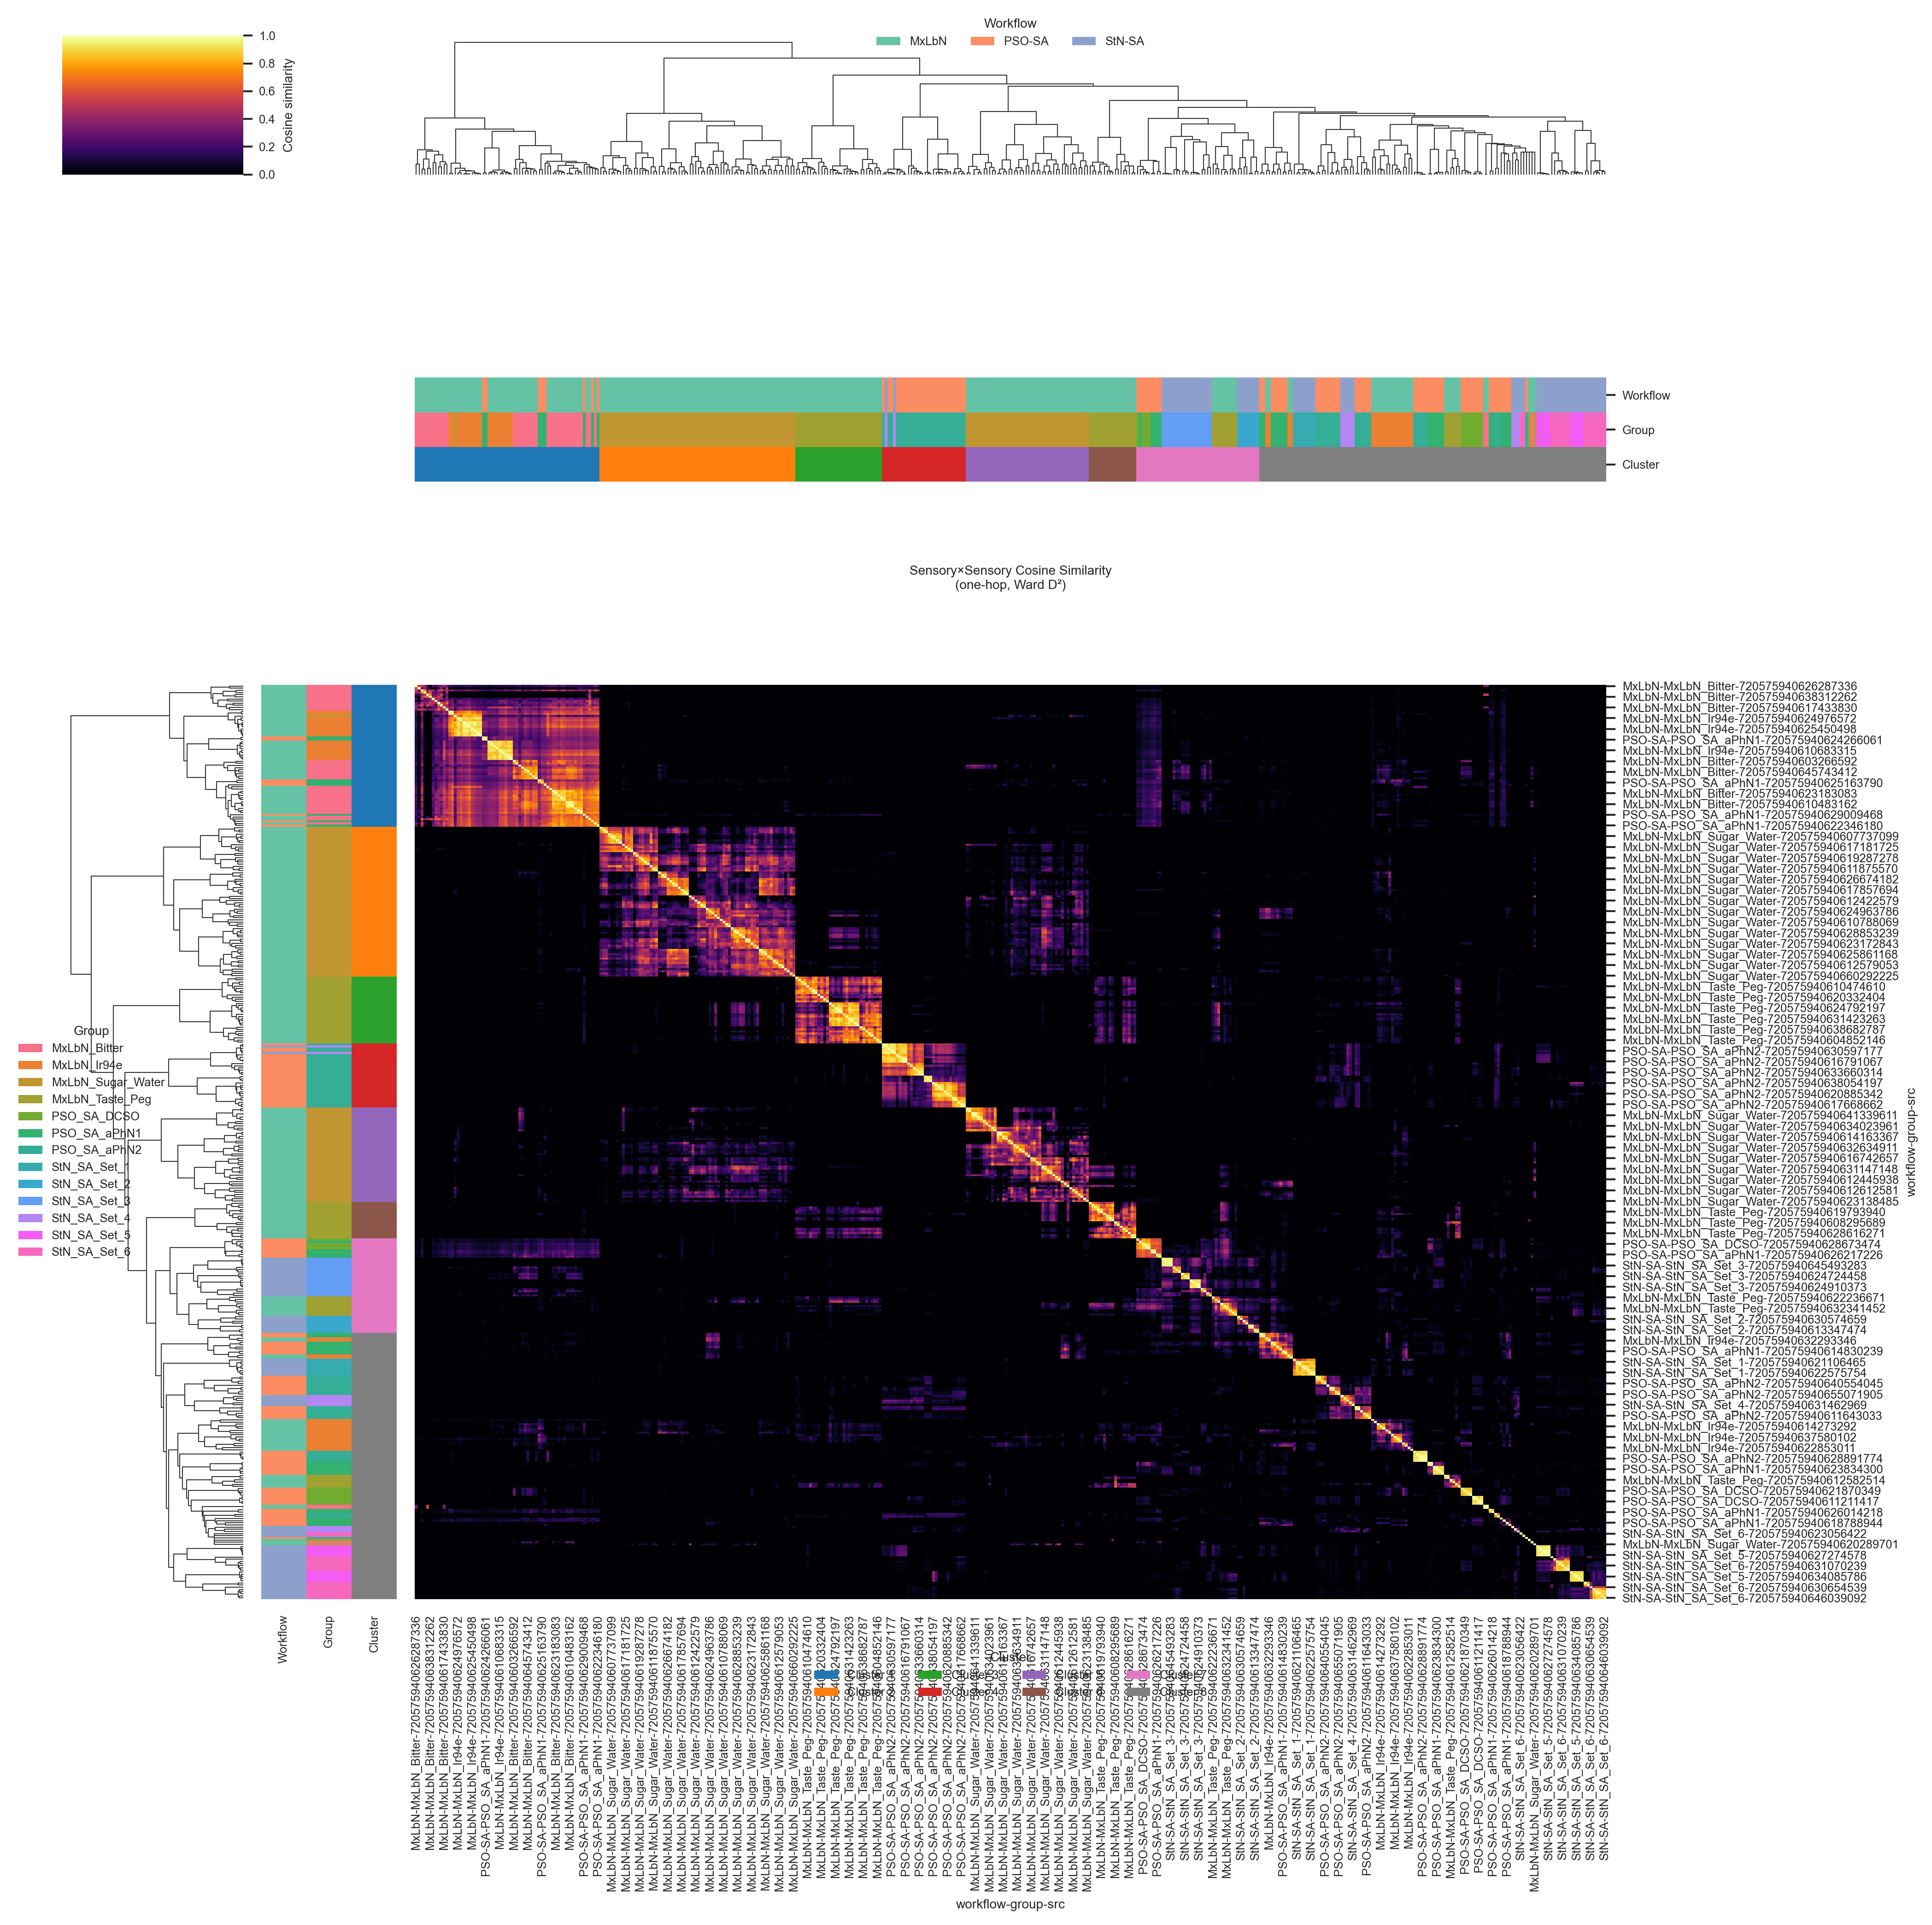

In [70]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance  import squareform
from sklearn.metrics         import pairwise_distances

def plot_cosine_heatmap_grouped(mat, n_clusters=8):
    # 1) Compute cosine-distance
    dist = pairwise_distances(mat.values, metric="cosine")
    sim  = 1 - dist
    sim_df = pd.DataFrame(sim, index=mat.index, columns=mat.index)

    # 2) Ward’s D² clustering
    condensed = squareform(dist)
    Z = linkage(condensed, method="ward")

    # 3) Cluster assignments
    cluster_labels = fcluster(Z, t=n_clusters, criterion='maxclust')
    clusters = pd.Series(cluster_labels, index=mat.index, name='Cluster')

    # 4) Workflow colors
    workflows = mat.index.get_level_values("workflow")
    uwf = sorted(set(workflows))
    pal_wf = sns.color_palette("Set2", n_colors=len(uwf))
    cmap_wf = dict(zip(uwf, pal_wf))
    wf_colors = [cmap_wf[w] for w in workflows]

    # 5) Group colors
    groups = mat.index.get_level_values("group")
    ug = sorted(set(groups))
    pal_g = sns.color_palette("husl", n_colors=len(ug))
    cmap_g = dict(zip(ug, pal_g))
    g_colors = [cmap_g[g] for g in groups]

    # 6) Cluster colors
    pal_c = sns.color_palette("tab10", n_colors=n_clusters)
    cmap_c = {i+1: pal_c[i] for i in range(n_clusters)}
    c_colors = clusters.map(cmap_c)

    # 7) Combine into DataFrame for color bars
    row_colors = pd.DataFrame({
        "Workflow": wf_colors,
        "Group":    g_colors,
        "Cluster":  c_colors
    }, index=mat.index)

    # 8) Draw the clustermap
    sns.set_context("paper", font_scale=0.7)
    cg = sns.clustermap(
        sim_df,
        row_linkage=Z, col_linkage=Z,
        row_colors=row_colors, col_colors=row_colors,
        cmap="inferno", center=0.5,
        figsize=(14,14),
        dendrogram_ratio=(0.12, 0.12),   # smaller so bars touch heatmap
        colors_ratio=(0.03, 0.03),       # small gap
        cbar_pos=(0.02, 0.8, 0.02, 0.18),# x, y, width, height
        cbar_kws={"label": "Cosine similarity"}
    )

    # 9) Workflow legend (top center, above dendrogram)
    for i, wf in enumerate(uwf):
        cg.ax_col_dendrogram.bar(0, 0,
                                 color=pal_wf[i],
                                 label=wf,
                                 linewidth=0)
    cg.ax_col_dendrogram.legend(
        title="Workflow",
        ncol=min(len(uwf),4),
        frameon=False,
        bbox_to_anchor=(0.5, 1.20),
        loc="upper center"
    )

    # 10) Group legend (directly left of row dendrogram)
    for i, grp in enumerate(ug):
        cg.ax_row_dendrogram.bar(0, 0,
                                 color=pal_g[i],
                                 label=grp,
                                 linewidth=0)
    cg.ax_row_dendrogram.legend(
        title="Group",
        ncol=1,
        frameon=False,
        bbox_to_anchor=(-0.30, 0.5),
        loc="center left"
    )

    # 11) Cluster legend (below heatmap)
    for cl in range(1, n_clusters+1):
        cg.ax_heatmap.bar(0, 0,
                          color=cmap_c[cl],
                          label=f"Cluster {cl}",
                          linewidth=0)
    cg.ax_heatmap.legend(
        title="Cluster",
        ncol=4,
        frameon=False,
        bbox_to_anchor=(0.5, -0.12),
        loc="lower center"
    )

    # 12) Title up top
    cg.ax_heatmap.set_title(
        "Sensory×Sensory Cosine Similarity\n(one-hop, Ward D²)",
        pad=50
    )

    plt.tight_layout()
    plt.show()



# ─── 7. MAIN ─────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    generate_one_hop(min_syn=5)
    mat = load_one_hop_matrix_grouped(binary=False)
    plot_cosine_heatmap_grouped(mat)

Written one‐hop CSVs → /Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/hops/sensory_to_all_downstream


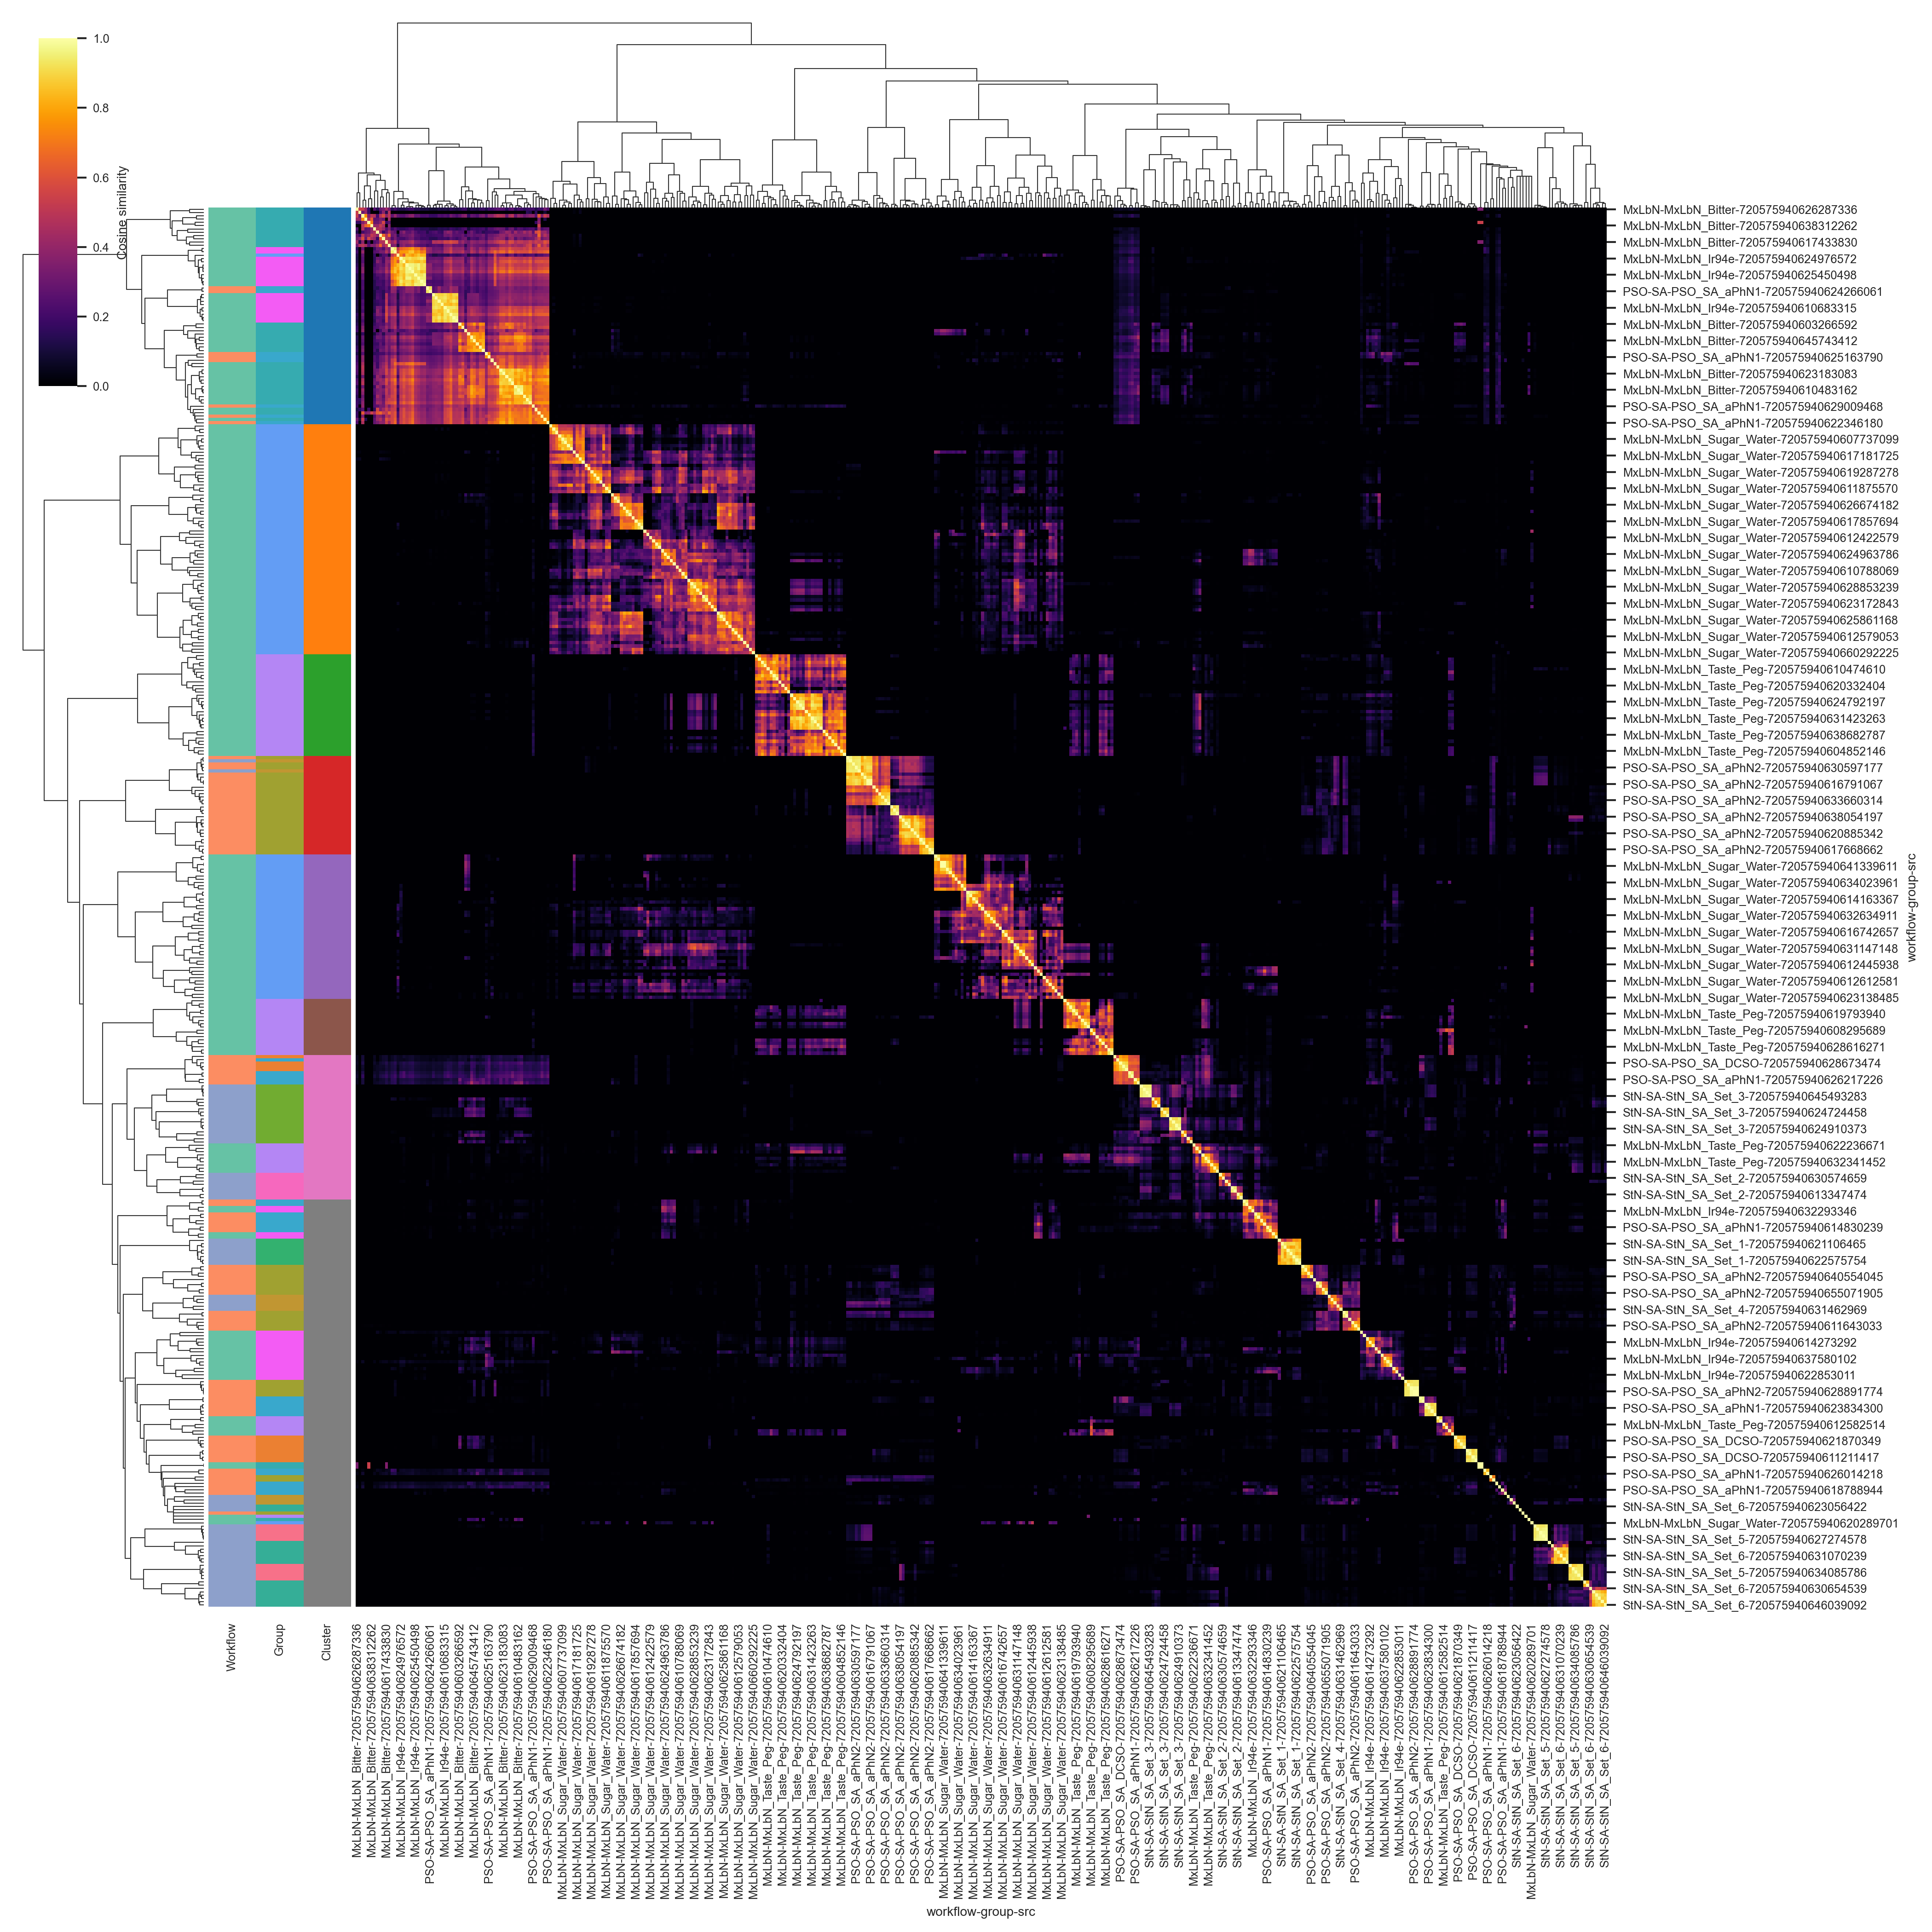

In [77]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance  import squareform
from sklearn.metrics         import pairwise_distances
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_cosine_heatmap_grouped(mat, n_clusters=8):
    # 1) cosine-distance & similarity
    dist = pairwise_distances(mat.values, metric="cosine")
    sim  = 1 - dist
    sim_df = pd.DataFrame(sim, index=mat.index, columns=mat.index)

    # 2) Ward’s D² linkage
    condensed = squareform(dist)
    Z = linkage(condensed, method="ward")

    # 3) build row_colors as before
    workflows = mat.index.get_level_values("workflow")
    pal_wf    = sns.color_palette("Set2", n_colors=len(set(workflows)))
    wf_colors = [pal_wf[list(set(workflows)).index(w)] for w in workflows]

    groups = mat.index.get_level_values("group")
    pal_g   = sns.color_palette("husl",  n_colors=len(set(groups)))
    g_colors = [pal_g[list(set(groups)).index(g)] for g in groups]

    cluster_labels = fcluster(Z, t=n_clusters, criterion='maxclust')
    pal_c    = sns.color_palette("tab10", n_colors=n_clusters)
    c_colors = [pal_c[c-1] for c in cluster_labels]

    row_colors = pd.DataFrame({
        "Workflow": wf_colors,
        "Group":    g_colors,
        "Cluster":  c_colors
    }, index=mat.index)

    # 4) draw clustermap WITHOUT col_colors
    cg = sns.clustermap(
        sim_df,
        row_linkage=Z, col_linkage=Z,
        row_colors=row_colors,         # only the left colorbar
        cmap="inferno", center=0.5,
        figsize=(14,14),
        dendrogram_ratio=(0.12, 0.12),  # keep your dendro height
        colors_ratio=(0.03, 0.0),       # zero space for col_colors
        cbar_pos=(0.02, 0.8, 0.02, 0.18),
        cbar_kws={"label": "Cosine similarity"}
    )

    # now nudge the column‐dendrogram down:
     # … after your sns.clustermap(...) call …

    # 1) Drop the (now empty) col_colors axis if it actually exists
    ax_col_colors = getattr(cg, "ax_col_colors", None)
    if ax_col_colors is not None:
        cg.fig.delaxes(ax_col_colors)

    # 2) Grab positions
    pos_heat = cg.ax_heatmap.get_position()
    pos_col  = cg.ax_col_dendrogram.get_position()

    # 3) Compute new height so top stays the same but bottom = heatmap top
    new_height = pos_col.y1 - pos_heat.y1

    # 4) Move the dendrogram down
    cg.ax_col_dendrogram.set_position([
        pos_col.x0,
        pos_heat.y1,
        pos_col.width,
        new_height
    ])

    plt.draw()

# ─── 7. MAIN ─────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    generate_one_hop(min_syn=5)
    mat = load_one_hop_matrix_grouped(binary=False)
    plot_cosine_heatmap_grouped(mat)
